In [1]:
import os
import numpy as np
import pandas as pd
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white')
sns.set_palette('deep');
from __future__ import print_function
drive_path = '/data/dynamic-brain-workshop/visual_behavior'


In [2]:
import swdb_2018_tools.noBehave.attention
import swdb_2018_tools.noBehave.Madison_functions_as_functions

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
import visual_behavior.ophys.plotting.summary_figures as sf
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from swdb_2018_tools.noBehave.attention import dataset_pull

In [4]:
manifest_file = 'visual_behavior_data_manifest.csv'
manifest = pd.read_csv(os.path.join(drive_path,manifest_file))

In [5]:
experiment_list = manifest['experiment_id']
experiment_list = experiment_list.tolist()

In [6]:
def dataset_pull(session , drive_path = None):
    #this function simplifies the loading of a dataset by assuming the drive_path
    #input session_id and output dataset object
    from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
    if drive_path == None:
        drive_path = '/data/dynamic-brain-workshop/visual_behavior'
    dataset = VisualBehaviorOphysDataset(session, cache_dir = drive_path)
    return(dataset)

In [7]:
def l0_event_pull(session):
    #input a session id, and output the array L0 events for each cell
    l0 = '/data/dynamic-brain-workshop/visual_behavior_events/%s_events.npz' % session
    l0_events = np.load(l0)['ev']
    return(l0_events)

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()


In [9]:
def model_test(session, model, l0 = False, smooth = False, solver = None):
    #this function requires a binary model and a set of training data to output the LDA analysis
    #as an option you can use l0 events as training data, and you can choose to smooth the data
    
    #option for different analysis type is available
    
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
    if l0 == False:
        training_data = dataset_pull(session)
    if l0 == True:
        training_data = l0_event_pull(session)
        
    if ((smooth == True)&(l0 == True)):
        return('This function is not yet supported')
    
    if ((smooth == True)&(l0 == False)):
        return('This function is not yet supported')
    
    time, trace = training_data.dff_traces
    if len(trace[0]) != len(model):
        return('Model does not match trace length for selected session')
    
    #ATTENTION
    #This step may need revision.  I believe the array needs to be reshaped in order to work but dont know why
    trace = np.swapaxes(trace, 0, 1)
    
    #This may also need revision, but its how I returned an output so I'm sticking with it
    
    if solver == None:
        solve = LinearDiscriminantAnalysis('svd')
    if solver == 'isqr':
        solve = LinearDiscriminantAnalysis('isqr')
    if solver == 'eigen':
        solve = LinearDiscriminantAnalysis('eigen')
    
    output = solve.fit_transform(trace, model)
    array = output[:,0]
    return(array)
    

In [10]:
def singletrial_eng_binary(trials, catch=False, preview = False):
    eng_binary= []
    for i in range(len(trials.trial)): #problem if remove ctch trials, differnt length?
        if ((trials.trial_type[i] == 'go') and (trials.response_type[i] == 'HIT')):
            success = 1
        elif((trials.trial_type[i] == 'go') and (trials.response_type[i] == 'MISS')):
            success = 0
        elif catch==False:
            continue
        elif catch == True:
            if ((trials.trial_type[i] == 'catch') and (trials.response_type[i] == 'CR')):
                success = 1
            elif((trials.trial_type[i] == 'catch') and (trials.response_type[i] == 'FA')):
                success = 0
            
        eng_binary.append(success)
        
    if preview == True:
        print("preview: ", eng_binary[:20], "length is: ", len(eng_binary)) 

    return(eng_binary)

In [11]:
def wide_engage_binary(trials,
                       trials_before_and_after=1,
                       num_successes=2,
                       preview = False,
                       catch = False):
    
    success_list = []

    #create column in dataframe: success
    for i in range(len(trials.trial)):
        if ((trials.trial_type[i] == 'go') and (trials.response_type[i] == 'HIT')):
            #create success column
            success = True
            
        elif catch == True:
            if ((trials.trial_type[i] == 'catch') and (trials.response_type[i] == 'CR')):
                success= True
        else:
            success = False

        success_list.append(success)
    trials['success'] = success_list
    
    width= trials_before_and_after
    wide_engage_binary = []

    for i in range(len(trials.trial)):
        #want to look at window from one trial before to one trial after. unless first of last trial, then there isnt a before or after trial respectively
        if i <= width:
            pre = 0
            post = (i+width)
        elif i + width >= len(trials.trial):
            pre= (i-width)
            post= len(trials.trial)
        else:
            pre= (i-width)
            post= (i+width)
        trialwindow = (trials[pre:(post+1)])#-1 because non-inclusive
        successonly_list = trialwindow.success[trialwindow.success == True]
        if len(successonly_list) >= num_successes:
            performing_task = 1
        else:
            performing_task = 0
        wide_engage_binary.append(performing_task)  
    #adds wide eng binary as a column in dataset
    trials["wide_engage_binary"]= wide_engage_binary

    #prints 4 columns to check your work
    if preview == True:
        
        print(trials[['trial_type','response_type','success', 'wide_engage_binary']])
    return(wide_engage_binary)

In [12]:
def eng_window(trials,
               catch=False,
               preview = False,
               change_1 = 0.75,
               change_2 = 0.15,
               pre_change = False,
               all_pre_change = False, 
               meta = False, 
               wide_model=False, 
               model = False):
    eng_st = []
    eng_end = []
    change_image_list = []
    if pre_change == True:
        pre_eng_st = []
        pre_eng_end = []
        
    for i in range(len(trials.trial)):
        if ((wide_model == True)|(model == True)):
            last_initial_image =(trials.change_time[i] - change_1)
            eng_st.append(last_initial_image)
            resp_window_start = (trials.change_time[i] + change_2)
            eng_end.append(resp_window_start)
            
        
        
        elif catch == False:
            if trials.trial_type[i] == 'go':
                last_initial_image =(trials.change_time[i] - change_1)
                eng_st.append(last_initial_image)
                resp_window_start = (trials.change_time[i] + change_2)
                eng_end.append(resp_window_start) 
                if pre_change ==True:
                        pre_last_initial_image =(last_initial_image - 0.75)
                        pre_eng_st.append(pre_last_initial_image)
                        pre_resp_window_start = (resp_window_start - 0.75)
                        pre_eng_end.append(pre_resp_window_start)

                        if all_pre_change == True:
                            trial_length =  trials.trial_length[i]
                            repeats = int(trial_length / 0.75)
                            way_back = 1
                            while repeats > 3:
                                pre_last_initial_image =(last_initial_image - (0.75+way_back))
                                pre_eng_st.append(pre_last_initial_image)
                                pre_resp_window_start = (resp_window_start - (0.75+way_back))
                                pre_eng_end.append(pre_resp_window_start)
                                repeats -=1
                                way_back += 1
            elif ((trials.trial_type[i] == 'catch') and (trials.response_type[i] == 'CR')):
                success= True   
                if meta == True:
                    change_image = trials.change_image_name[i]
                    change_image_list.append(change_image)
        if catch== True:
            last_initial_image =(trials.change_time[i] - change_1)
            eng_st.append(last_initial_image)
            resp_window_start = (trials.change_time[i] + change_2)
            eng_end.append(resp_window_start) 
    
    if preview == True:
        
        print("preview: ", eng_st[:3], eng_end[:3], "length is: ", len(eng_st))
    if pre_change == True:
        return(eng_st, eng_end, pre_eng_st, pre_eng_end)
    if meta == True:
        return(eng_st, eng_end, change_image_list)
    else:
        return(eng_st, eng_end)

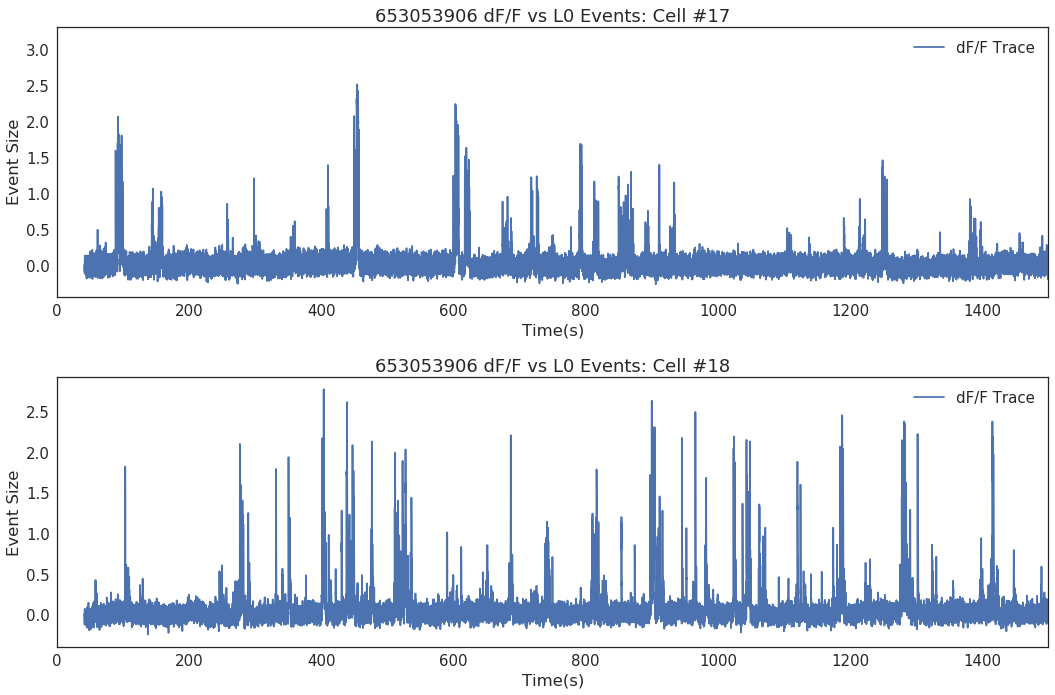

In [44]:
graph_compare(slc_visp_nontrash[1], slc_visp_nontrash[1], cell_1 = 17, cell_2 = 18, dff=True, xlim1 = 0, xlim2 = 1500)

In [32]:
def graph_compare(mouse1,
                  mouse2,
                  xlim1=None,
                  xlim2=None,
                  xlim3=None,
                  xlim4=None,
                  stims = False,
                  cell_1 = 0,
                  cell_2 = 0,
                  l0=False, 
                  dff = False, 
                  no_compare = False, 
                  title = None): 
    #This function inputs two mice and xlimits, and will output 
    #two graphs with overlayed dff trace and L0 events, with stim events included
    if xlim3 == None:
        xlim3 = xlim1
        xlim4 = xlim2
    slc = mouse1
    vip = mouse2
    if l0==True:
        l0_events_vip = l0_event_pull(vip)
        l0_events_slc = l0_event_pull(slc)
    
    dataset_vip = VisualBehaviorOphysDataset(vip, cache_dir = drive_path)
    dataset_slc = VisualBehaviorOphysDataset(slc, cache_dir = drive_path)
    
    times_vip, traces_vip = dataset_vip.dff_traces
    times_slc, traces_slc = dataset_slc.dff_traces
    
    figsize = (15,10)
    fig, (ax1, ax2) = plt.subplots(2,1,figsize = figsize)
    if dff == True:
        ax1.plot(times_vip, traces_vip[cell_1], label = 'dF/F Trace')
    if l0==True:
        ax1.plot(times_vip, l0_events_vip[cell_1], label = 'L0 Events')

    if stims == True:
        
        for index in dataset_vip.stimulus_table.index:
            trial_change = dataset_vip.trials.change_time
            row_data = dataset_vip.stimulus_table.iloc[index]
            rewarded = dataset_vip.rewards.time
            trial_change = dataset_vip.trials.change_time
            if ((row_data.start_time >= xlim1)&(row_data.end_time <= xlim2)):
                ax1.axvspan(xmin=row_data.start_time,xmax=row_data.end_time,facecolor='gray',alpha=0.3)
            if np.any(trial_change.isin([row_data.start_time])) == True:
                trial_change = trial_change.tolist()
                ind = trial_change.index(row_data.start_time)
                ax1.vlines(dataset_vip.trials.change_time[ind], -0.5, 0)
            reward_window = []
            for n in rewarded:
                if ((n >= xlim1)&(n <= xlim2)):
                    reward_window.append(n)
            reward_y_vals = np.repeat(-0.5, repeats = len(reward_window))
            ax1.plot(reward_window,reward_y_vals, marker='o',linestyle='None')
    if dff ==True:
        ax2.plot(times_slc, traces_slc[cell_2], label = 'dF/F Trace')
    if l0==True:
        ax2.plot(times_slc,l0_events_slc[cell_2], label = 'L0 Events')

    if stims == True:
        
        for index in dataset.stimulus_table.index:
            trial_change = dataset_slc.trials.change_time
            row_data = dataset_slc.stimulus_table.iloc[index]
            trial_change = dataset_slc.trials.change_time
            rewarded = dataset_slc.rewards.time
            if ((row_data.start_time >= xlim3)&(row_data.end_time <= xlim4)):
                ax2.axvspan(xmin=row_data.start_time,xmax=row_data.end_time,facecolor='gray',alpha=0.3)
            if np.any(trial_change.isin([row_data.start_time])) == True:
                trial_change = trial_change.tolist()
                ind = trial_change.index(row_data.start_time)
                ax2.vlines(dataset_slc.trials.change_time[ind], -0.5, 0)
            reward_window = []
            for n in rewarded:
                if ((n >= xlim3)&(n <= xlim4)):
                    reward_window.append(n)     
            reward_y_vals = np.repeat(-0.5,repeats=len(reward_window))
            ax2.plot(reward_window,reward_y_vals,marker='o',linestyle='None')

    ax1.set_xlim(xlim1,xlim2)
    ax2.set_xlim(xlim3,xlim4)


    ax1.set_title(str(mouse1)+' dF/F vs L0 Events: Cell #'+str(cell_1))
    ax2.set_title(str(mouse2)+' dF/F vs L0 Events: Cell #'+str(cell_2))
    ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('Event Size')
    
    ax1.legend()
    ax2.legend()
    
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Event Size')
    fig.tight_layout()
    ax1.legend()

In [15]:
def experiment_snip(experiment, start_list, end_list):
    #This is a sub-function that will be called within trace_snip
    #This function inputs one experiment, a start/end list and outputs an array of each cells trace in the experiment
    
    experiment = dataset_pull(experiment)
    time, trace = experiment.dff_traces
    
    trace_array = []
    
    for cell in trace:
        time_list =[]
        trace_list = []
        for i, start_time in enumerate(start_list):
            start_time = start_list[i]
            end_time = end_list[i]
            domain_indices = np.where(np.logical_and(time >=start_time, time < end_time))
            current_trace = cell[domain_indices]
            current_times = time[domain_indices]
            trace_list.extend(current_trace)
            time_list.extend(current_times)
        trace_array.append(trace_list)
        
        #return(current_trace)
        #break
    return(time_list, trace_array)

# in dev

In [16]:
def trace_snip(experiment,
               start_list,
               end_list,
               smooth = False,
               l0 = False,
               window_limit = 45,
               change_1 = 0.75,
               change_2 = 0.15,
               pre_change = False,
               pre_start_list = None,
               pre_end_list = None,
               all_pre_change = False,
               process = False, 
               per_cell = False, 
               one_cell = False, 
               pre_process=False):
    #Inputs dataframe, start times and stop times.  Outputs snips of neuron activity between the specified times
    #Experiment should be a VisualBehaviorOphysDataset object
    #Start should be a list of start times
    #End should be a list of end times
    frames = int((change_1 +change_2) * 30)
    trace_list = []
    time_list = []
    
    
    
    if len(start_list) != len(end_list):
        return('List of start and end times do not match')

    if ((l0 == True)&(smooth ==True)):
        return('I dont want to smooth an L0!')

    if l0 == True:
        exp_id = experiment.experiment_id
        l0 = '/data/dynamic-brain-workshop/visual_behavior_events/%s_events.npz' % exp_id
        trace = np.load(l0)['ev']
        time = experiment.timestamps_ophys

    else:
        time, trace = experiment.dff_traces

    for cell in trace:
        trace_list_temp = []
        if smooth == True:
            box = np.ones(10)/10
            cell = np.convolve(cell, box, 'same')
            
        if all_pre_change == False:    
            for j, start_time in enumerate(start_list):
                if pre_change == True:
                    pre_start_time = pre_start_list[j]
                    pre_end_time = pre_end_list[j]
                    domain_indices = np.where(np.logical_and(time >=pre_start_time, time < pre_end_time))
                    current_trace = cell[domain_indices]
                    current_times = time[domain_indices]
                    trace_list_temp.append(current_trace[:frames])
                    time_list.append(current_times)

                start_time = start_list[j]
                end_time = end_list[j]
                domain_indices = np.where(np.logical_and(time >=start_time, time < end_time))
                current_trace = cell[domain_indices]
                current_times = time[domain_indices]
                if process == True:
                    current_trace=current_trace.mean()
                    trace_list_temp.append(current_trace)
                else:
                    trace_list_temp.append(current_trace[:frames])
                time_list.append(current_times)
                
            if per_cell == True:
#                 if pre_process == True:
#                     trace_mean = np.mean(trace_list_temp)
#                     trace_list.append(trace_mean)
#                 else:
                trace_list.append(trace_list_temp)
            else:
                trace_list.extend(trace_list_temp)
            
        if all_pre_change == True:
            for j, pre_start_time in enumerate(pre_start_list):
                pre_start_time = pre_start_list[j]
                pre_end_time = pre_end_list[j]
                domain_indices = np.where(np.logical_and(time >=pre_start_time, time < pre_end_time))
                current_trace = cell[domain_indices]
                current_times = time[domain_indices]
                trace_list_temp.extend(current_trace[:frames])
                time_list.append(current_times)
            trace_list.append(trace_list_temp)
        if one_cell == True:
            break
    if pre_process == True:
        trace_list = np.reshape(trace_list, (len(trace_list[0]), len(experiment.cell_indices)))
        trace_df = pd.DataFrame(trace_list)
        trace_df['mean_trace'] = trace_df.mean(axis=1)
        trace_list = trace_df['mean_trace'].tolist()
        
    return(trace_list, time_list)

# in dev

In [17]:
def engagement_a(experiment_list,
                 smooth = False,
                 l0 = False,
                 preview = False,
                 change_1 = 0.75,
                 change_2 = 0.15,
                 catch = False,
                 pre_change =False,
                 all_pre_change = False, 
                 process = False,
                 per_cell = False, 
                 model = False, 
                 wide_model = False, 
                 trials_before_and_after = 1, 
                 num_successes = 2,
                 time = False, 
                 meta = False, 
                 one_exp = False, 
                 one_cell = False, 
                 pre_process = False):    
    
    #Experiment List: Requires experiment ids to be analyzed.  Must be a list
    #Smooth: If True, the program will return a smoothed trace instead of the raw dF/F
    #l0 : If True, the program will return the l0 Events instead of trace
    #preview: Used for printing a preview of the time window snips
    #change_1/change_2: Used to determine the window around the image change. change_1 is time in seconds before, change_2 is after
    #catch:  By default the program will return only Hits and Misses from 'go' trials.  If True, catch trials will be included
    #pre_change: If True, the program will pull both the change window, and the window of the last two image presentations
    #all_pre_change: If True, the program will only pull pre_change windows for the whole trial, except for the first 3 presentations
    #process: If True, the output of the trace/events will be the mean in that window rather than the full snip
    #per_cell: If True, returns the trace_array in a format that compares cells over trials.  Best used for one experiment
    #model: If True, will return the basic short window binary array corresponding to datapoints
    #wide_model: If True, will return the rolling "graded" binary window 
    #trials_before_and_after/num_success: If wide_model = True, these values are used to determine the grading for the engagement window. By default is 2/3
    #time: If True, will return the timepoints related to the snips
    #meta: If True, will return metadata such as presentation image type
    #one_exp: Use to reduce function run time and pull only information from the first experiment in the list
    #one_cell: same as one_exp, but only runs one cell
    
    
    
    
    #pass in a list of experiments and return an arrary of engagement binaries, and two arrays of start/end times
    
    
    #IN DEVELOPMENT
    #Optional argument for creating wide binary and wider binary
    

    eng_binary_array = []
    eng_trace_array = []
    eng_time_array = []
    for experiment in experiment_list:
        eng_start_array = []
        eng_end_array = []
        dataset = dataset_pull(experiment)
        trials = dataset.trials
        #create dataframe with engagement windows and simple engagement binary
        if pre_change == True:
            eng_st, eng_end, pre_eng_st, pre_eng_end = eng_window(trials,
                                                                  preview = preview,
                                                                  change_1 = change_1,
                                                                  change_2=change_2,
                                                                  catch= catch,
                                                                  pre_change= pre_change,
                                                                  all_pre_change = all_pre_change, 
                                                                  meta = meta)
        elif meta == True:
            pre_eng_st = None
            pre_eng_end = None
            eng_st, eng_end, change_image_list = eng_window(trials,
                                         preview = preview,
                                         change_1 = change_1,
                                         change_2=change_2,
                                         catch= catch,
                                         pre_change= pre_change, 
                                         meta = meta)
            
            
        else:
            pre_eng_st = None
            pre_eng_end = None
            eng_st, eng_end = eng_window(trials,
                                         preview = preview,
                                         change_1 = change_1,
                                         change_2=change_2,
                                         catch= catch,
                                         pre_change= pre_change, 
                                         meta = meta, 
                                         wide_model = wide_model, 
                                         model = model)
            
        if model == True:
            eng_binary_temp = singletrial_eng_binary(trials,
                                                     preview = preview)
            
        if wide_model == True:
            eng_binary_temp = wide_engage_binary(trials, 
                                                preview = preview, 
                                                trials_before_and_after = trials_before_and_after, 
                                                num_successes = num_successes, 
                                                catch = catch)
            
        trace_output, time_output_temp = trace_snip(dataset,
                                                    eng_st,
                                                    eng_end,
                                                    smooth=smooth,
                                                    l0=l0,
                                                    change_1=change_1,
                                                    change_2=change_2,
                                                    pre_change = pre_change,
                                                    pre_start_list = pre_eng_st,
                                                    pre_end_list = pre_eng_end,
                                                    all_pre_change = all_pre_change, 
                                                    process = process,
                                                    per_cell = per_cell, 
                                                    one_cell = one_cell, 
                                                    pre_process = pre_process)
        
        if pre_process == True:
            eng_trace_array.extend(trace_output)
        else:
            eng_trace_array.append(trace_output)
        eng_time_array.append(time_output_temp)
        
        if ((per_cell == False)&((model==True)|(wide_model==True))):
            for cells in range(len(dataset.cell_specimen_ids)):
                eng_binary_array.extend(eng_binary_temp)
        elif ((model == True)|(wide_model==True)):
            eng_binary_array.extend(eng_binary_temp)
        if one_exp == True:
            break
    if ((model == True)|(wide_model==True)):           
        eng_binary_array = np.array(eng_binary_array)
        
#INTERPRETING OF TRACE_OUTPUT
#The first level of the array is the index of the experiment in the list of experiments
#The second level of the array is the cell index from that experiment, and every trial
#The third level of the array is the trace

#IF PRE_CHANGE is TRUE
#The order of the trace list will be: evens are pre change, odds are post change

    trace_output = np.array(eng_trace_array)
    time_output = np.array(eng_time_array)
    if ((model == False)&(time==True)):
        return(trace_output, time_output)
    if (((model == True)|(wide_model == True))&(time==False)):
        return(trace_output, eng_binary_array)
    if ((model == False)&(time == False)&(meta == False)):
        return(trace_output)
    if meta == True:
        return(trace_output, change_image_list)
    return(eng_binary_array, trace_output, time_output)

In [78]:
vip = manifest[manifest['cre_line']=='Vip-IRES-Cre']
vip_visp = vip[vip.targeted_structure == 'VISp']
vip_visal = vip[vip.targeted_structure == 'VISal']
vip_visal_experiments = vip_visal.experiment_id
vip_visp_experiments = vip_visp.experiment_id
vip_visal_experiments= vip_visal_experiments[9]

slc = manifest[manifest['cre_line']=='Slc17a7-IRES2-Cre']
slc_visp = slc[slc.targeted_structure == 'VISp']
slc_visp_experiments = slc_visp.experiment_id
slc_visp_nontrash = slc_visp_experiments.reset_index(drop=True)
slc_visp_nontrash = slc_visp_nontrash[1:]

(-0.5, 446.5, 511.5, -0.5)

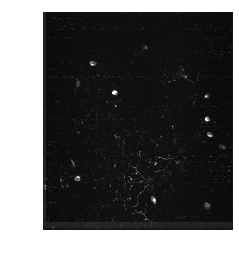

In [27]:
dataset = dataset_pull(vip_visal_experiments[9])
plt.imshow(dataset.max_projection,cmap='gray',)
plt.axis('off')

In [79]:
dff_trace_array, model = engagement_a([vip_visal_experiments],
                                        change_2 = 0.25,
                                        process = True, 
                                        l0 = True, 
                                        one_cell =False, 
                                        one_exp = True, 
                                        per_cell = True, 
                                        wide_model = True, 
                                        pre_process= False, 
                                        pre_change = False,
                                        all_pre_change = False)


In [80]:
print(model.shape)
print(dff_trace_array.shape)
#print(len(dff_trace_array))
#print(time_array.shape)

(344,)
(1, 17, 344)


In [81]:
from sklearn import model_selection
from sklearn.decomposition import PCA

In [82]:
print(dff_trace_array.shape)
X = dff_trace_array[0]
X = X.T
print(X.shape)
#y = model

(1, 17, 344)
(344, 17)


In [83]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0.5,1,'Principle Components \nMean dF/F VISal #1: All-Pre)')

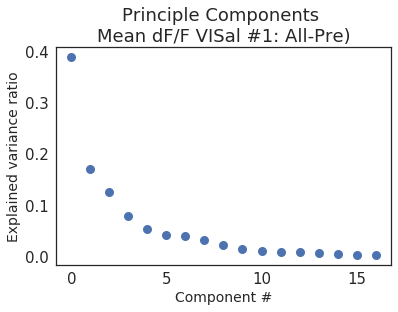

In [84]:
plt.plot(pca.explained_variance_ratio_, 'o')
plt.xlabel("Component #", fontsize=14)
plt.ylabel("Explained variance ratio", fontsize=14)
plt.title('Principle Components \nMean dF/F VISal #1: All-Pre)')

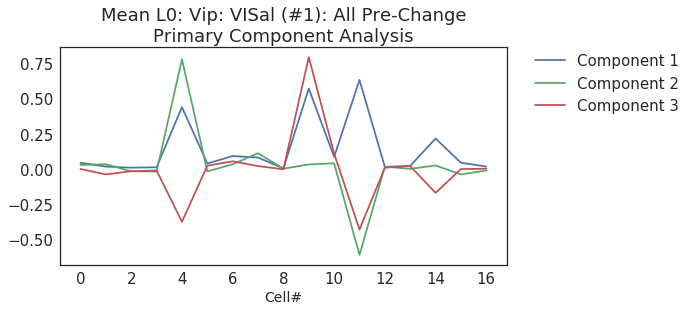

In [85]:
# plt.plot(pca.components_[0], label = 'Component 1')
# plt.plot(pca.components_[1], label = 'Component 2')
# plt.plot(pca.components_[2], label = 'Component 3')
# plt.xlabel(('Cell#'), fontsize = 14)
# plt.title('Mean dF/F During Change \nPrimary Component Analysis')
# plt.figure(figsize = (2,5))
# plt.legend()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(pca.components_[0], label = 'Component 1')
ax.plot(pca.components_[1], label = 'Component 2')
ax.plot(pca.components_[2], label = 'Component 3')
#ax.plot(pca.components_[3], label = 'Component 4')
#ax.plot(pca.components_[4], label = 'Component 5')
#ax.plot(pca.components_[5], label = 'Component 6')
ax.set_xlabel(('Cell#'), fontsize = 14)
ax.set_title('Mean L0: Vip: VISal (#1): All Pre-Change\nPrimary Component Analysis')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [86]:
weights = pca.fit_transform(X)
weights.shape

(344, 17)

Text(0.5,1,'Mean dF/F During Change \nPrimary Component 2')

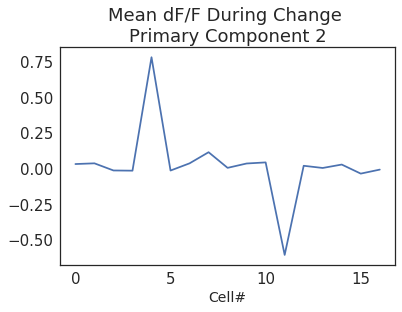

In [87]:
plt.plot(pca.components_[1])
plt.xlabel(('Cell#'), fontsize = 14)
plt.title('Mean dF/F During Change \nPrimary Component 2')

Text(0.5,1,'Mean dF/F During Change \nPrimary Component 3')

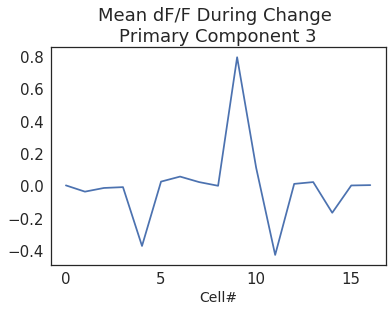

In [88]:
plt.plot(pca.components_[2])
plt.xlabel(('Cell#'), fontsize = 14)
plt.title('Mean dF/F During Change \nPrimary Component 3')

In [89]:
pca_df = pd.DataFrame(weights[:,[0,1,2]])
pca_array = pca_df.as_matrix()
pca_array.shape

(344, 3)

In [90]:
pca_array.shape

(344, 3)

In [91]:
print(pca_array.shape)
print(model.shape)
X = pca_array
y = model
#X = X.T
#print(X.shape)

(344, 3)
(344,)


In [92]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(X,y,test_size=0.2)

print(np.shape(X_train))
print(np.shape(y_train))

(275, 3)
(275,)


In [93]:
from sklearn.neighbors import KNeighborsClassifier

In [94]:
classifier = LinearDiscriminantAnalysis()
classifier.fit(X_train,y_train)
y_hat = classifier.predict(X_test)

In [95]:
scores = model_selection.cross_validate(classifier,X,y)
print(scores['test_score'])
print(scores['train_score'])
test_avg = round(np.average(scores['test_score']), 2)
train_avg = round(np.average(scores['train_score']), 2)
test_std = round(np.std(scores['test_score']), 2)
train_std = round(np.std(scores['train_score']),2)
error = [test_std, train_std]
print(test_std)
print(train_std)
print(test_avg)
print(train_avg)

[0.74137931 0.74561404 0.74561404]
[0.75438596 0.76521739 0.75652174]
0.0
0.0
0.74
0.76


In [96]:
classifier_k = KNeighborsClassifier()
classifier_k.fit(X_train, y_train)
y_hat_k = classifier.predict(X_test)
scores_k = model_selection.cross_validate(classifier_k,X,y)
ktest_std = round(np.std(scores_k['test_score']),2)
ktrain_std = round(np.std(scores_k['train_score']),2)
ktest_avg = round(np.average(scores_k['test_score']), 2)
ktrain_avg = round(np.average(scores_k['train_score']), 2)
print(scores_k['test_score'])
print(scores_k['train_score'])
k_error = [ktest_std, ktrain_std]

[0.73275862 0.71929825 0.75438596]
[0.79824561 0.80869565 0.7826087 ]


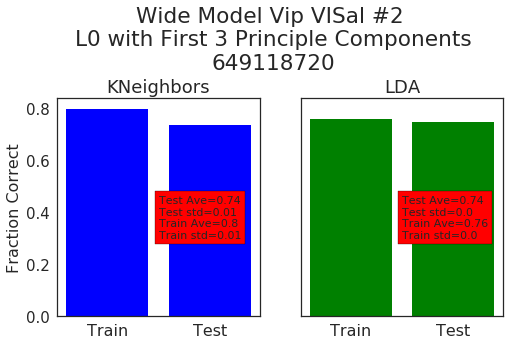

In [99]:
scores_k = model_selection.cross_validate(classifier_k,X,y)
# test = scores['test_score']
# test = test.tolist()
# train = scores['train_score']
# train = train.tolist()
# test.extend(train)

# test1 =['test', 'test', 'test', 'train','train', 'train']
# empty_df = pd.DataFrame()
# empty_df['category'] = test1
# empty_df['value'] = test
# empty_df
# sns.barplot(empty_df)
# #empty_df

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (8, 4),sharey = True)
#ax1 = plt.subplot(111)
ax1.bar([0,1],[np.mean(scores_k['train_score']),np.mean(scores_k['test_score'])],color='b')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Train','Test'],fontsize=16)
ax1.set_ylabel('Fraction Correct',fontsize=16)
ax1.set_title('KNeighbors')
fig.suptitle('Wide Model Vip VISal #2 \nL0 with First 3 Principle Components\n'+str(vip_visal_experiments), y = 1.2)
ax2.bar([0,1], [np.mean(scores['train_score']),np.mean(scores['test_score'])],color='g')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['Train','Test'],fontsize=16)
ax2.set_ylabel('')
ax2.set_title('LDA')
ax1.text(0.5, 0.3,
         'Test Ave='+str(ktest_avg)+'\nTest std='+str(ktest_std)+'\nTrain Ave='+str(ktrain_avg)+'\nTrain std='+str(ktrain_std),
         fontsize = 11, bbox = dict(facecolor='red'))
ax2.text(0.5, 0.3,
         'Test Ave='+str(test_avg)+'\nTest std='+str(test_std)+'\nTrain Ave='+str(train_avg)+'\nTrain std='+str(train_std),
         fontsize = 11, bbox = dict(facecolor = 'red'))
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [68]:
vip_visal_experiments

8     648647430
9     649118720
10    649318212
32    700914412
33    701325132
34    702134928
35    702723649
44    715161256
45    715887497
46    716327871
47    716600289
Name: experiment_id, dtype: int64

In [362]:
print("Test Performance: " + str(np.mean(y_test == y_hat)))

Test Performance: 0.6363636363636364


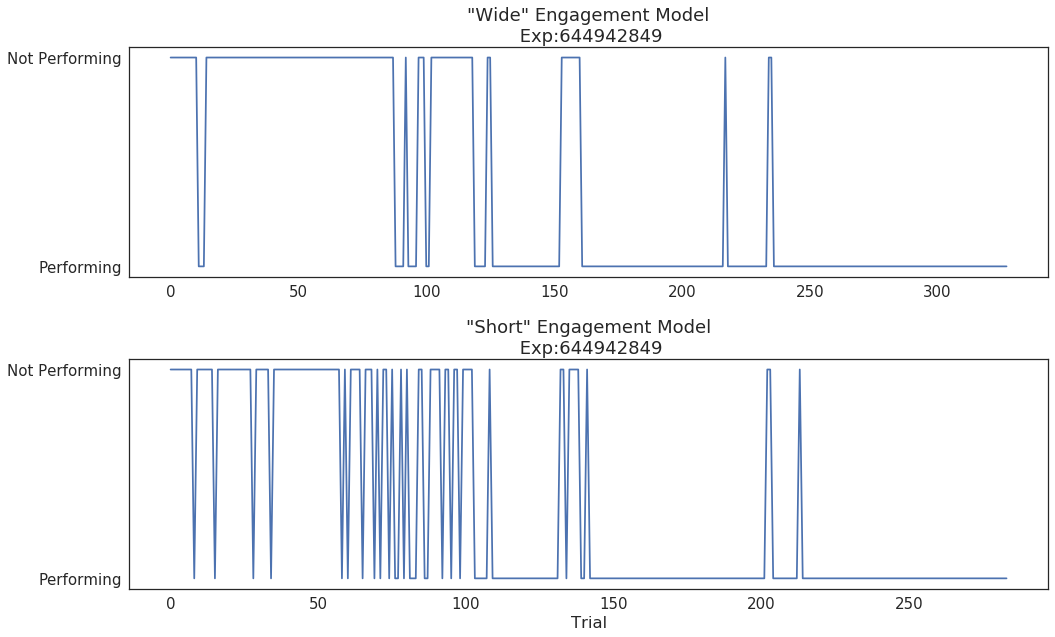

In [35]:
figsize = (15,10)
fig, (ax1, ax2) = plt.subplots(2,1,figsize = figsize)
ax1.plot(model_array)
ax1.set_title('"Wide" Engagement Model\n Exp:'+str(experiment_list[0]))
#ax1.set_xlabel('Trial')
ax1.set_yticks([0,1])
ax1.set_yticklabels(['Performing', 'Not Performing'])


ax2.set_title('"Short" Engagement Model\n Exp:'+str(experiment_list[0]))
ax2.set_xlabel('Trial')
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Performing', 'Not Performing'])
ax2.plot(model_array_old)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

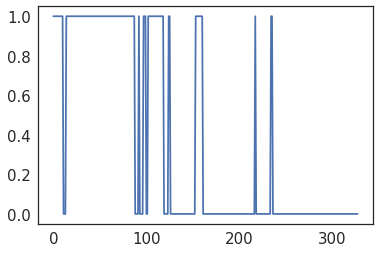

In [332]:
plt.plot(model_array)

In [322]:
print(len(model_array))
print(len(trace_array[0]))
#print(len(time_array[0]))

0
12


In [62]:
plt.plot(trace_array[0][0])

Engaged n=79
Not Engaged n=21


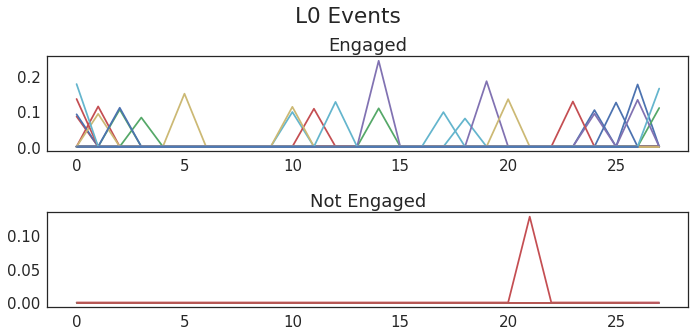

In [435]:
on_list = []
off_list = []

for i in range(100):
    j = model_array[i]
    if j == 1:
        on_list.append(trace_array[0][0][i])
    else:
        off_list.append(trace_array[0][0][i])
figsize = (10,5)
fig, (ax1, ax2) = plt.subplots(2,1, figsize= figsize)    
    
for i in range(len(on_list)):

    ax1.plot(on_list[i])
    ax1.set_title('Engaged')
for i in range(len(off_list)):
    ax2.plot(off_list[i])
    ax2.set_title('Not Engaged')
    
fig.suptitle('L0 Events')    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

print('Engaged n='+str(len(on_list)))
print('Not Engaged n=' +str(len(off_list)))

In [40]:
for k in range(len(trace_array)):
    for j in range(len(trace_array[k])):    
        on_list = []
        off_list = []
        for i in range(len(trace_array[k][j])):
            h = model_array[i]
            if h == 1:
                on_list.append(trace_array[k][j][i])
            else:
                off_list.append(trace_array[k][j][i])
        figsize = (10,5)
        fig, (ax1, ax2) = plt.subplots(2,1, figsize= figsize)    

        for i in range(len(on_list)):

            ax1.plot(on_list[i])
            ax1.set_title('Engaged')
        for i in range(len(off_list)):
            ax2.plot(off_list[i])
            ax2.set_title('Not Engaged')
        ax1.text(25, 0.2, 'n='+str(len(on_list))) 
        ax2.text(25, 0.25, 'n=' +str(len(off_list)))
        fig.suptitle('L0 Events: Experiment'+str(experiment_list[k])+'Cell index #' +str(0))    
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('figures/l0_traces/'+str(experiment_list[k])+'cell'+str(j)+'.png')
        plt.close(fig)

In [39]:
print(j)

12


In [212]:
#test_array = np.concatenate([time_array, model_array, trace_array])
test_frame = pd.DataFrame([time_array, model_array, trace_array])
#test_frame = pd.melt(test_frame)
test_frame.head()

0    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [0.11173426018250905, -0.12004908460292316, 0....   

                                                 1    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [-0.06312552803415351, 0.03718801551214124, -0...   

                                                 2    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [0.013034993422511743, -0.02740234564255018, 0...   

                                                 3    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [-0.1240148302999453, 0.031206601962293953, -0...   

                                                 4    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [-0.11389858881156839, -0.10880200147474006, 0...   

                                                 5    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [-0.03076503612450143, -0.16801192075663907, 0...   

                                                 6    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [0.0513585083557765, -0.04142858483702054, -0....   

                                                 7    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [0.025047549609346458, -0.1052980706368759, 0....   

                                                 8    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [0.07591879114095051, 0.12305338240722777, 0.0...   

                                                 9    \
0  [203.72555, 203.75784, 203.79013, 203.82242, 2...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2  [0.3895395406533674, 0.377258369047255, 0.1993...   

                         ...                          \
0                        ...                           
1                        ...                           
2                        ...                           

                                                 228  \
0  [146.96359, 146.99588, 147.02817, 147.06046, 1...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [-0.08949135754336021, 0.05087003211670113, -0...   

                                                 229  \
0  [146.96359, 146.99588, 147.02817, 147.06046, 1...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [-0.12820087501334645, 0.05207224051001207, -0...   

                                                 230  \
0  [146.96359, 146.99588, 147.02817, 147.06046, 1...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [-0.03636423522576314, -0.08952194215846562, 0...   

                                                 231  \
0  [146.96359, 146.99588, 147.02817, 147.06046, 1...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.010016277640528507, -0.11058698147182262, -...   

                                                 232  \
0  [146.96359, 146.99588, 147.02817, 147.06046, 1...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [-0.07683983768937028, -0.2207382050103203, -0...   

                                                 233  \
0  [146.96359, 146.99588, 147.02817, 147.06046, 1...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [-0.06888456386835215, -0.15973872344840886, -...   

                                                 234  \
0  [146.96359, 146.99588, 147.02817, 147.06046, 1...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [-0.06263375036840851, -0.05484544515731788, 0...   


In [ ]:
test_frame.to_csv()

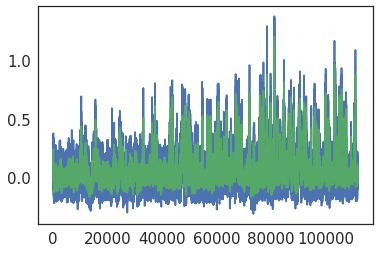

In [133]:
experiment = dataset_pull(experiment_list[1])
time, trace = experiment.dff_traces
for cell in trace:
    box = np.ones(10)/10
    cell = np.convolve(cell, box, 'same')
    break
plt.plot(trace[0])
plt.plot(cell)
#plt.xlim(0, 10000)


In [145]:
time = dataset.get_timestamps_ophys()
time

array([ 177.89405,  177.92634,  177.95862, ..., 3783.8529 , 3783.8852 ,
       3783.9175 ])

(4000, 6000)

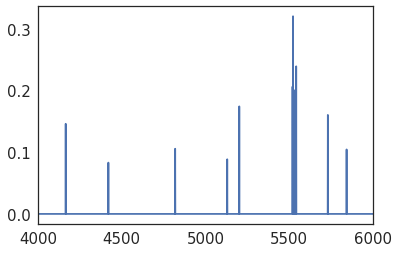

In [107]:
plt.plot(trace_array[0])
plt.xlim(4000,6000)

(4000, 6000)

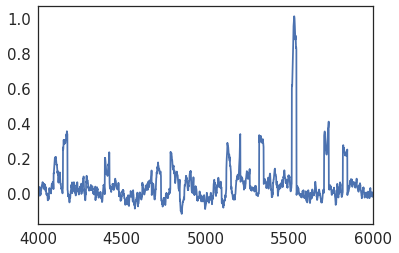

In [105]:
plt.plot(trace_array[0])
plt.xlim(4000,6000)

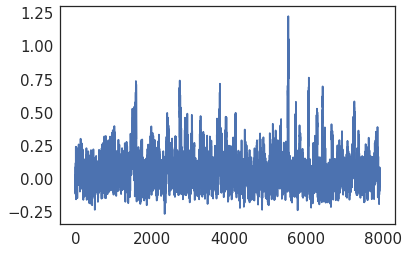

In [127]:
plt.plot(trace_array[0])
#plt.xlim(4000,6000)
plt.plot(model_array[0])

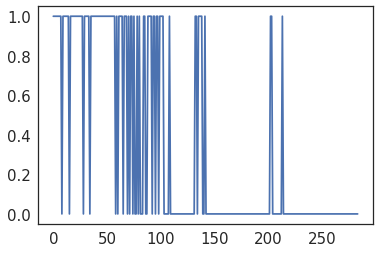

In [152]:
plt.plot(model_array[0])

In [17]:
manifest_vip = manifest[manifest.cre_line == 'Vip-IRES-Cre']
manifest_vip_visp = manifest_vip[manifest_vip.targeted_structure == 'VISp']
vip_visp_experiments = manifest_vip_visp['experiment_id']
vip_visp_experiments = vip_visp_experiments.tolist()
vip_visp_experiments

[644942849,
 645035903,
 645086795,
 645362806,
 646922970,
 647108734,
 647551128,
 647887770,
 695471168,
 696136550,
 698244621,
 698724265,
 712178916,
 712860764,
 713525580,
 714126693]

In [21]:
for i in range(len(trace_array)):
    print(len(trace_array[i]))

7913
7913
7913
7913
7913
7913
7913
7913
7913
7913
7913
7913
7973
7973
7973
7973
7973
7973
7973
7973
7973
7973
7973
7966
7966
7966
7966
7966
7966
7966
7966
7966
7966
7966
7966
7966
7469
7469
7469
7469
7469
7469
7469
7469
7469
7469
7469
8973
8973
8973
8973
8973
8973
8973
8973
8973
8973
8973
8973
8973
8973
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
8894
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
9218
7885
7885
7885
7885
7885
7885
7885
7885
7885
7885
7885
7885
7885
7885
7885
7885
7885
7428
7428
7428
7428
7428
7428
7428
7428
7428
7428
7428
7428
7428
7428
9330
9330
9330
9330
9330
9330
9330
9330
9330
9330
9330
9330
9330
9330
9330
9330
9330
8610
8610
8610
8610
8610
8610
8610
8610
8610
8610
8610
8610
8610
7689
7689
7689
7689
7689
7689
7689
7689
7689
7689
7689
7689
7689
7689
7500
7500
7500
7500
7500
7500
7500
7500
7500
7500
7500
7500
7500
7500
5934
5934
5934
5934
5934
5934
5934
5934
5934
5934
5934
5934


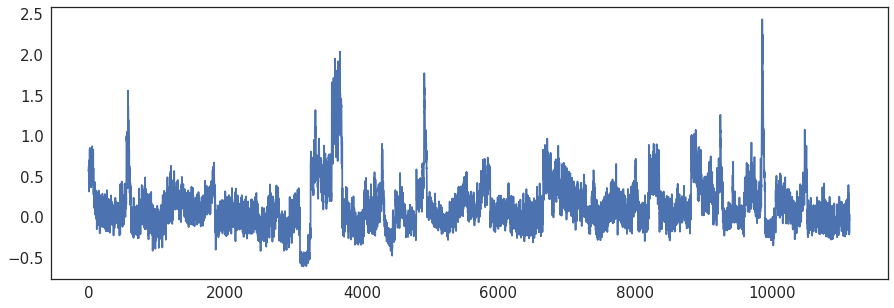

In [133]:
test_list =[180, 190, 200, 500]
test_list2 = [185, 195, 205, 505]
time, trace = experiment_snip(dataset, test_list, test_list2)
#print(time)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(trace)

#domain_ones

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


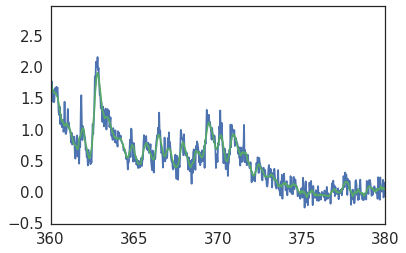

In [32]:
exp=experiment_list[5]
dataset = dataset_pull(experiment_list[5])
time, trace = dataset.dff_traces
just_one = trace[0]
box = np.ones(10)/10
smooth_data = np.convolve(just_one, box, 'same')

plt.plot(time, just_one)
plt.plot(time, smooth_data)
plt.xlim(360, 380)
plt.show()

In [22]:
#this cell generates the fake model for LDA
times, traces = train_data.get_dff_traces()
model = []
test = 0
for i, time in enumerate(times):
    random = np.random.randint(1, 50000)
    if i % random == 0:
        test +=1
    if test % 2 == 0:
        model.append(1)
    else:
        model.append(0)



NameError: name 'train_data' is not defined

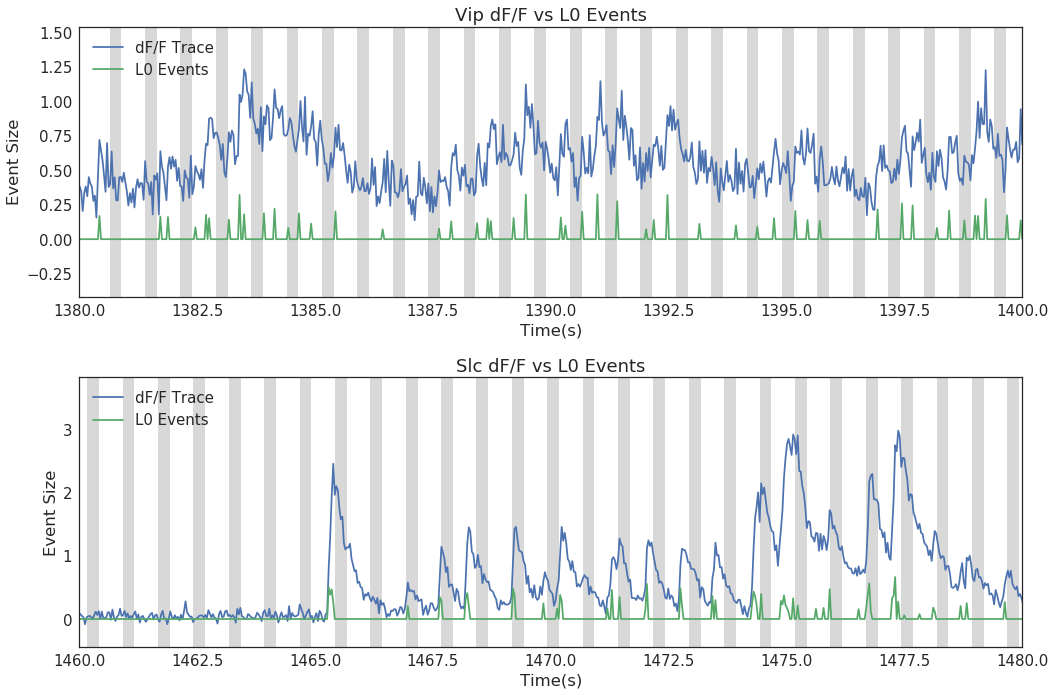

In [141]:
graph_compare(652844352,644942849,1380,1400,1460,1480, stims = True)

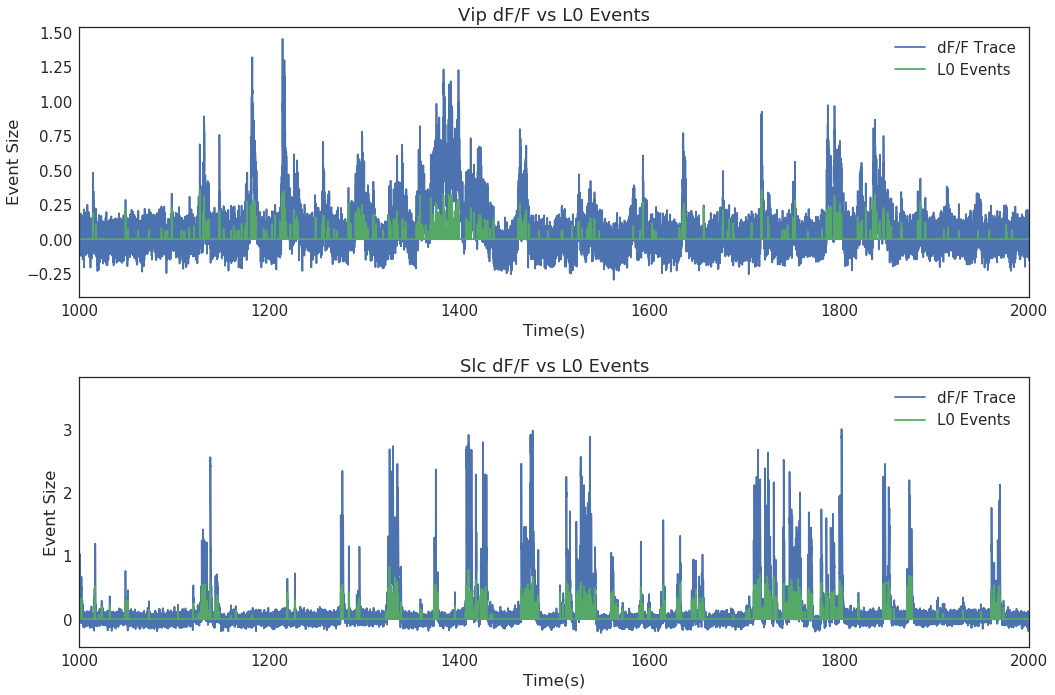

In [134]:
graph_compare( 652844352, 644942849, 1000, 2000)

In [401]:
dataset = dataset_pull(644942849)

In [28]:
slc = 652844352
vip = 644942849

In [59]:
l0_events_vip = l0_event_pull(vip)
l0_events_slc = l0_event_pull(slc)

In [60]:
dataset_vip = VisualBehaviorOphysDataset(vip, cache_dir = drive_path)
dataset_slc = VisualBehaviorOphysDataset(slc, cache_dir = drive_path)

In [61]:
times_vip, traces_vip = dataset_vip.dff_traces
times_slc, traces_slc = dataset_slc.dff_traces

In [112]:
#dataset.stimulus_table
ax1.set_xlim(1380,1400)
ax2.set_xlim(1460,1510)

In [79]:
graph_compare()

array([  57.13618,   57.16846,   57.20074, ..., 3664.75788, 3664.79018,
       3664.82248])

In [5]:
current_exp = manifest.set_index('experiment_id',inplace=True)
current_exp = current_exp[current_exp['targeted_structure']=='VISp']
current_exp = current_exp.sort_index

NameError: name 'current_exp' is not defined

In [241]:
def make_lick_raster(trials):
    fig,ax = plt.subplots(figsize=(5,10))
    for trial in trials.trial.values: 
        trial_data = trials.iloc[trial]
        # get times relative to change time
        trial_start = trial_data.start_time - trial_data.change_time
        lick_times = [(t - trial_data.change_time) for t in trial_data.lick_times]
        reward_time = [(t - trial_data.change_time) for t in trial_data.reward_times]
        # plot trials as colored rows
        ax.axhspan(trial, trial + 1, -200, 200, color=trial_data.trial_type_color, alpha=.5)
        # plot reward times
        if len(reward_time) > 0:
            ax.plot(reward_time[0], trial + 0.5, '.', color='b', label='reward', markersize=6)
        ax.vlines(trial_start, trial, trial + 1, color='black', linewidth=1)
        # plot lick times
        ax.vlines(lick_times, trial, trial + 1, color='k', linewidth=1)
        # annotate change time
        ax.vlines(0, trial, trial + 1, color=[.5, .5, .5], linewidth=1)
    # gray bar for response window
    ax.axvspan(trial_data.response_window[0], trial_data.response_window[1], facecolor='gray', alpha=.4,
               edgecolor='none')
    ax.grid(False)
    ax.set_ylim(0, len(trials))
    ax.set_xlim([-1, 4])
    ax.set_ylabel('trials')
    ax.set_xlabel('time (sec)')
    ax.set_title('lick raster')
    plt.gca().invert_yaxis()



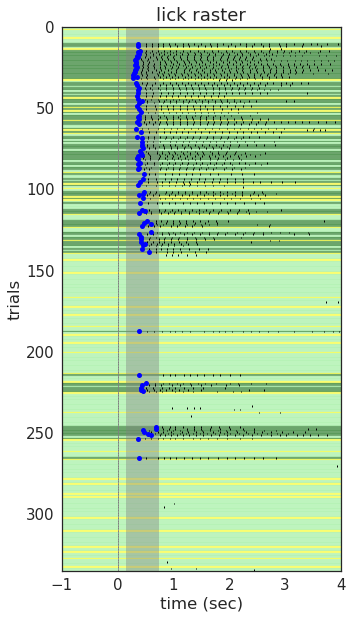

In [242]:


slc_test = dataset_pull(slc_visp_nontrash[1])
slc_licks = slc_test.licks
dataset = dataset_pull(slc_visp_nontrash[1])
make_lick_raster(dataset.trials)

In [239]:
slc_visp_nontrash

1     653053906
2     653123781
3     639253368
4     639438856
5     639769395
6     639932228
7     670396087
8     671152642
9     672185644
10    672584839
11    685744008
12    686726085
13    720001924
14    720793118
15    723064523
16    723750115
Name: experiment_id, dtype: int64

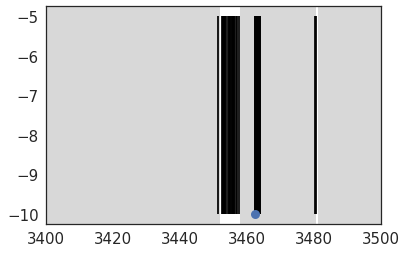

In [85]:
# rewards = dataset.get_rewards()
# dis = rewards[rewards['time']>200]
# dis
#lick_y_vals = np.repeat(-10,repeats=len(dataset.licks.time.values))
plt.vlines(dataset.licks.time.values, -10, -5, label='licks')
plt.xlim(3400,3500)
for index in dataset.trials.index:
    row_data = dataset.trials.iloc[index]
    plt.axvspan(xmin=row_data.start_time,xmax=row_data.end_time,facecolor='gray',alpha=0.3)
reward_y_vals = np.repeat(-10,repeats=len(dataset.rewards.time.values))
plt.plot(dataset.rewards.time.values,reward_y_vals,marker='o',linestyle='None',label='rewards',)

In [123]:
# series = dataset.timestamps
# series = series['lick_times'].values.tolist()
# series = series[0]
# len(series)
dataset.timestamps.head()

cam1_exposure  \
timestamps  [0.47835, 0.50202, 0.51095, 0.54148, 0.5747, 0...   

                                                cam2_exposure  \
timestamps  [0.54513, 0.56345, 0.5659, 0.59772, 0.63155, 0...   

                                                   lick_times  \
timestamps  [150.69202, 150.8696, 155.93274, 156.13005, 15...   

                                                 ophys_frames ophys_trigger  \
timestamps  [143.84855, 143.88084, 143.91312, 143.94541, 1...   [139.92014]   

                                              stim_photodiode  \
timestamps  [150.97195, 152.97358, 154.97522, 156.97684, 1...   

                                              stimulus_frames  
timestamps  [149.98284, 149.99946, 150.01615, 150.0328, 15...

In [122]:
dataset.get_licks().head()

frame       time
0     46  150.74988
2     57  150.93330
4    360  155.98744
7    372  156.18759
9    382  156.35444

In [148]:
dataset.trials.head()

trial  change_time initial_image_name change_image_name trial_type  \
0      0    116.58841              im085             im065         go   
1      1    124.84513              im065             im066         go   
2      2    133.10193              im066             im062         go   
3      3    141.35861              im062             im065         go   
4      4    149.61534              im065             im062         go   

  trial_type_color  response response_type response_window lick_times  \
0       lightgreen       0.0          MISS    [0.15, 0.75]         []   
1       lightgreen       0.0          MISS    [0.15, 0.75]         []   
2       lightgreen       0.0          MISS    [0.15, 0.75]         []   
3       lightgreen       0.0          MISS    [0.15, 0.75]         []   
4       lightgreen       0.0          MISS    [0.15, 0.75]         []   

   response_latency  rewarded reward_times  reward_volume  reward_rate  \
0               NaN      True           []            0.0     0.977929   
1               NaN      True           []            0.0     0.946098   
2               NaN      True           []            0.0     0.916275   
3               NaN      True           []            0.0     0.888274   
4               NaN      True           []            0.0     0.861934   

   start_time   end_time  trial_length mouse_id  \
0   112.06804  120.32477      8.256808  M333706   
1   120.32477  128.58147      8.256811  M333706   
2   128.58147  136.83823      8.256881  M333706   
3   136.83823  145.09500      8.256929  M333706   
4   145.09500  153.35168      8.256772  M333706   

                    start_date_time  
0  2017-12-08 13:19:51.023000-08:00  
1  2017-12-08 13:19:51.023000-08:00  
2  2017-12-08 13:19:51.023000-08:00  
3  2017-12-08 13:19:51.023000-08:00  
4  2017-12-08 13:19:51.023000-08:00

In [154]:
auto = dataset.all_trials
auto = auto[auto['auto_rewarded']==True]
dataset.all_trials

auto_rewarded  change_contrast  change_frame change_image_category  \
0             None              1.0           NaN                         
1             True              1.0         495.0                 im061   
2             None              1.0           NaN                         
3             True              1.0        1125.0                 im062   
4             True              1.0        1620.0                 im069   
5             None              1.0           NaN                         
6             None              1.0           NaN                         
7             None              1.0           NaN                         
8             None              1.0           NaN                         
9             True              1.0        2115.0                 im062   
10            True              1.0        2565.0                 im085   
11            None              1.0        3105.0                 im065   
12            None              1.0        3600.0                 im066   
13            None              1.0        4095.0                 im062   
14            None              1.0        4590.0                 im065   
15            None              1.0        5085.0                 im062   
16            None              1.0        5580.0                 im061   
17            None              1.0        5985.0                 im066   
18            None              1.0        6480.0                 im063   
19            None              1.0        6975.0                 im085   
20            True              1.0        7470.0                 im069   
21            None              1.0        8190.0                 im077   
22            None              1.0        8685.0                 im085   
23            None              1.0        9180.0                 im063   
24            None              1.0        9675.0                 im077   
25            None              1.0       10170.0                 im063   
26            None              1.0       10665.0                 im066   
27            None              1.0       10935.0                 im085   
28            None              1.0       11430.0                 im062   
29            None              1.0       11925.0                 im077   
...            ...              ...           ...                   ...   
1021          None              1.0           NaN                         
1022          None              1.0      213496.0                 im069   
1023          None              1.0           NaN                         
1024          None              1.0           NaN                         
1025          None              1.0           NaN                         
1026          None              1.0           NaN                         
1027          None              1.0           NaN                         
1028          None              1.0           NaN                         
1029          None              1.0           NaN                         
1030          None              1.0           NaN                         
1031          None              1.0           NaN                         
1032          None              1.0           NaN                         
1033          None              1.0           NaN                         
1034          None              1.0           NaN                         
1035          None              1.0           NaN                         
1036          None              1.0           NaN                         
1037          None              1.0           NaN                         
1038          None              1.0           NaN                         
1039          None              1.0           NaN                         
1040          None              1.0           NaN                         
1041          None              1.0           NaN                         
1042          None            

In [99]:

ophys = dataset.get_timestamps_ophys()
print(ophys[0])

stim_timer = dataset.get_timestamps_stimulus()
print(stim_timer[0])

dataset.timestamps

143.84855
149.98284


cam1_exposure  \
timestamps  [0.47835, 0.50202, 0.51095, 0.54148, 0.5747, 0...   

                                                cam2_exposure  \
timestamps  [0.54513, 0.56345, 0.5659, 0.59772, 0.63155, 0...   

                                                   lick_times  \
timestamps  [150.69202, 150.8696, 155.93274, 156.13005, 15...   

                                                 ophys_frames ophys_trigger  \
timestamps  [143.84855, 143.88084, 143.91312, 143.94541, 1...   [139.92014]   

                                              stim_photodiode  \
timestamps  [150.97195, 152.97358, 154.97522, 156.97684, 1...   

                                              stimulus_frames  
timestamps  [149.98284, 149.99946, 150.01615, 150.0328, 15...

In [151]:
len(dataset.get_rewards())

67

In [137]:
reward = dataset.get_trials()
reward = reward[reward['rewarded']==True]
reward

trial  change_time initial_image_name change_image_name trial_type  \
0        0    212.30009              im077             im063         go   
1        1    227.31230              im063             im085         go   
3        3    260.33925              im085             im069         go   
4        4    273.85029              im069             im063         go   
6        6    293.36621              im063             im066         go   
8        8    324.14135              im066             im065         go   
9        9    355.66714              im065             im062         go   
10      10    365.42506              im062             im065         go   
11      11    375.18306              im065             im066         go   
12      12    390.19527              im066             im069         go   
13      13    402.95572              im069             im062         go   
14      14    425.47411              im062             im063         go   
15      15    429.97777              im063             im065         go   
17      17    450.99502              im065             im085         go   
18      18    477.26644              im085             im063         go   
19      19    485.52318              im063             im069         go   
20      20    509.54277              im069             im085         go   
21      21    517.04893              im085             im061         go   
23      23    532.81178              im061             im063         go   
24      24    541.06853              im063             im077         go   
25      25    549.32528              im077             im061         go   
26      26    560.58449              im061             im062         go   
27      27    568.84124              im062             im077         go   
28      28    577.09800              im077             im069         go   
30      30    607.87316              im069             im077         go   
31      31    616.12984              im077             im066         go   
32      32    640.14956              im066             im062         go   
34      34    660.41609              im062             im069         go   
35      35    668.67284              im069             im065         go   
36      36    675.42834              im065             im069         go   
..     ...          ...                ...               ...        ...   
336    336   3450.57965              im077             im063         go   
337    337   3461.83875              im063             im065         go   
338    338   3470.84607              im065             im077         go   
339    339   3479.10287              im077             im085         go   
341    341   3492.61390              im085             im065         go   
342    342   3500.87069              im065             im062         go   
343    343   3509.12743              im062             im077         go   
344    344   3517.38415              im077             im062         go   
345    345   3525.64095              im062             im085         go   
346    346   3533.89765              im085             im077         go   
347    347   3542.15438              im077             im069         go   
348    348   3550.41114              im069             im077         go   
349    349   3558.66794              im077             im061         go   
351    351   3573.68012              im061             im069         go   
352    352   3581.93690              im069             im061         go   
353    353   3590.19365              im061             im063         go   
355    355   3603.70471              im063             im085         go   
356    356   3614.21330              im085             im061         go   
357    357   3632.97865              im085             im069         go   
358    358   3641.23536              im069             im065         go   
359    359   3649.49206              im065             im085         go   
360    360   3657.74886       

In [141]:
auto_r = dataset.all_trials
auto_r = auto_r[auto_r['auto_rewarded']==True]
auto_r.head()

auto_rewarded  change_contrast  change_frame change_image_category  \
1           True              1.0         316.0                 im065   
2           True              1.0         811.0                 im061   
7           True              1.0        2116.0                 im077   
8           True              1.0        2611.0                 im065   
10          True              1.0        3196.0                 im077   

   change_image_name  change_ori  change_time  cumulative_reward_number  \
1              im065        90.0    155.25353                         1   
2              im061        90.0    163.51026                         2   
7              im077        90.0    185.27804                         3   
8              im065        90.0    193.53469                         4   
10             im077        90.0    203.29269                         5   

    cumulative_volume  delta_ori  ...   number_of_rewards  rig_id trial_type  \
1               0.005        0.0  ...                   1     2P6         go   
2               0.010        0.0  ...                   1     2P6         go   
7               0.015        0.0  ...                   1     2P6         go   
8               0.020        0.0  ...                   1     2P6         go   
10              0.025        0.0  ...                   1     2P6         go   

                                          lick_frames  \
1                      [360, 372, 382, 395, 408, 419]   
2   [816, 844, 855, 866, 878, 889, 902, 912, 923, ...   
7   [2145, 2158, 2165, 2174, 2182, 2190, 2199, 220...   
8   [2631, 2643, 2651, 2658, 2669, 2677, 2686, 269...   
10  [3222, 3230, 3236, 3243, 3252, 3260, 3268, 327...   

                                         reward_licks reward_lick_count  \
1   [0.7505899999999883, 0.9507399999999961, 1.117...                 6   
2   [0.10008999999999446, 0.5671800000000076, 0.75...                14   
7   [0.5003800000000069, 0.7172300000000007, 0.834...                21   
8   [0.3503000000000043, 0.5504400000000089, 0.683...                23   
10  [0.45040999999997666, 0.5838200000000029, 0.68...                23   

    reward_lick_latency  reward_rate response color  
1               0.75059          inf      1.0  blue  
2               0.10009          inf      1.0  blue  
7               0.50038          inf      1.0  blue  
8               0.35030          inf      1.0  blue  
10              0.45041     3.806421      1.0  blue  

[5 rows x 63 columns]

In [86]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

In [82]:
# response = dataset.get_trials()
# fa = response[response['response_type']=='FA']
# fa
trialsss = dataset.get_all_trials()
auto_reward = trialsss[trialsss['auto_rewarded'] == True]
auto_reward

hits = dataset.get_trials()
hitlist = hits[hits['response_type']=='HIT']
hitlist

trial  change_time initial_image_name change_image_name trial_type  \
0        0    212.30009              im077             im063         go   
1        1    227.31230              im063             im085         go   
3        3    260.33925              im085             im069         go   
6        6    293.36621              im063             im066         go   
8        8    324.14135              im066             im065         go   
9        9    355.66714              im065             im062         go   
10      10    365.42506              im062             im065         go   
11      11    375.18306              im065             im066         go   
12      12    390.19527              im066             im069         go   
13      13    402.95572              im069             im062         go   
15      15    429.97777              im063             im065         go   
17      17    450.99502              im065             im085         go   
19      19    485.52318              im063             im069         go   
20      20    509.54277              im069             im085         go   
21      21    517.04893              im085             im061         go   
25      25    549.32528              im077             im061         go   
26      26    560.58449              im061             im062         go   
28      28    577.09800              im077             im069         go   
31      31    616.12984              im077             im066         go   
32      32    640.14956              im066             im062         go   
34      34    660.41609              im062             im069         go   
35      35    668.67284              im069             im065         go   
39      39    700.94919              im063             im061         go   
40      40    707.70469              im061             im069         go   
41      41    719.71457              im069             im061         go   
42      42    726.47009              im061             im065         go   
44      44    742.98355              im063             im062         go   
45      45    755.74396              im062             im066         go   
48      48    776.76118              im077             im062         go   
49      49    785.76850              im062             im085         go   
..     ...          ...                ...               ...        ...   
165    165   1920.82949              im066             im085         go   
167    167   1938.84416              im077             im066         go   
168    168   1947.10094              im066             im065         go   
170    170   1973.37245              im065             im085         go   
171    171   1981.62920              im085             im069         go   
172    172   1992.88837              im069             im065         go   
174    174   2019.91047              im077             im065         go   
175    175   2025.91537              im065             im069         go   
178    178   2054.43867              im077             im069         go   
184    184   2108.48281              im062             im061         go   
186    186   2121.99389              im063             im085         go   
187    187   2133.25308              im085             im061         go   
188    188   2140.75923              im061             im085         go   
189    189   2147.51473              im085             im069         go   
191    191   2164.02823              im069             im085         go   
194    194   2187.29723              im066             im069         go   
195    195   2196.30469              im069             im061         go   
196    196   2201.55889              im061             im069         go   
198    198   2221.07486              im062             im066         go   
200    200   2237.58833              im077             im062         go   
201    201   2245.84508              im062             im069         go   
206    206   2297.63742       

In [410]:
vip_trial = dataset.trials
vip_trial.response_type.unique()
vip_active = vip_trial[vip_trial['response_type'].isin(['HIT', 'FA'])]
vip_switch = []
for row in range(len(vip_active)):
    start = vip_active.iloc[row]['start_time']
    end = vip_active.iloc[row]['end_time']
    vip_switch.append(start)
    vip_switch.append(end)
vip_switch

[196.94456,
 208.20372,
 208.20372,
 216.46048,
 232.97391,
 241.23068,
 244.23318,
 252.48981,
 263.74912,
 272.00576,
 287.01808,
 295.27481,
 298.27722,
 306.53402,
 327.55118,
 332.80548,
 332.80548,
 341.06224,
 347.06713,
 350.82016,
 358.32634,
 366.58307,
 375.59051,
 383.84713,
 387.60023,
 395.85704,
 410.1186,
 418.3754,
 426.63214,
 434.88887,
 449.15051,
 457.40729,
 495.68856,
 504.69595,
 504.69595,
 512.9526000000001,
 515.20452,
 523.4612500000001,
 527.9649400000001,
 536.2216800000001,
 562.4931600000001,
 572.25115,
 572.25115,
 580.5078900000001,
 603.7769300000001,
 613.53488,
 618.7891800000001,
 628.54718,
 628.54718,
 636.8039100000001,
 639.80633,
 648.0630600000001,
 650.31497,
 658.57167,
 675.8358000000001,
 684.09253,
 701.3565900000001,
 710.3639900000001,
 729.87994,
 738.88729,
 738.88729,
 747.14409,
 750.1465000000001,
 758.40326,
 760.65506,
 768.91187,
 783.17352,
 791.43025,
 835.7164700000001,
 843.9732300000001,
 845.4743900000001,
 853.714490000

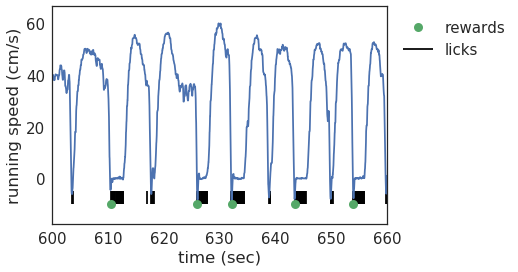

In [400]:
slc_test = dataset
plt.plot(dataset.timestamps_stimulus,dataset.running_speed.running_speed.values)
plt.xlim(600,660)
# plot rewards
reward_y_vals = np.repeat(-10,repeats=len(dataset.rewards.time.values))
plt.plot(dataset.rewards.time.values,reward_y_vals,marker='o',linestyle='None',label='rewards',)
# plot licks
lick_y_vals = np.repeat(-10,repeats=len(dataset.licks.time.values))
plt.vlines(dataset.licks.values, -10, -5, label='licks')

plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')
plt.legend(loc=9, bbox_to_anchor=(1.2,1))

In [369]:
slc_table = slc_test.get_stimulus_table()
slc_table.head()

flash_number  start_time  end_time image_name
0             0    64.82974  65.06301      im066
1             1    65.56355  65.81366      im066
2             2    66.31410  66.56425      im066
3             3    67.06463  67.31488      im066
4             4    67.81530  68.06550      im066

In [396]:
slc_test.trials

trial  change_time initial_image_name change_image_name trial_type  \
0        0    116.58841              im085             im065         go   
1        1    124.84513              im065             im066         go   
2        2    133.10193              im066             im062         go   
3        3    141.35861              im062             im065         go   
4        4    149.61534              im065             im062         go   
5        5    157.87208              im062             im061         go   
6        6    164.62759              im061             im066         go   
7        7    172.88428              im066             im063         go   
8        8    181.14102              im063             im085         go   
9        9    201.40761              im069             im077         go   
10      10    209.66430              im077             im085         go   
11      11    217.92106              im085             im063         go   
12      12    226.17783              im063             im077         go   
13      13    234.43452              im077             im063         go   
14      14    242.69127              im063             im066         go   
15      15    247.19496              im066             im085         go   
16      16    255.45172              im085             im062         go   
17      17    263.70839              im062             im077         go   
18      18    271.96520              im077             im065         go   
19      19    280.22193              im065             im063         go   
20      20    288.47863              im063             im063      catch   
21      21    296.73541              im063             im061         go   
22      22    304.99227              im061             im063         go   
23      23    313.24893              im063             im069         go   
24      24    321.50567              im069             im069      catch   
25      25    329.76237              im069             im085         go   
26      26    338.01907              im085             im066         go   
27      27    347.02646              im066             im066      catch   
28      28    355.28324              im066             im065         go   
29      29    363.53991              im065             im085         go   
..     ...          ...                ...               ...        ...   
275    275   3195.57101              im066             im069         go   
276    276   3215.83755              im069             im069      catch   
277    277   3224.09428              im069             im066         go   
278    278   3232.35108              im066             im061         go   
279    279   3240.60782              im061             im069         go   
280    280   3248.86459              im069             im061         go   
281    281   3257.12131              im061             im066         go   
282    282   3263.12622              im066             im065         go   
283    283   3271.38294              im065             im065      catch   
284    284   3279.63972              im065             im062         go   
285    285   3287.89644              im062             im061         go   
286    286   3361.45654              im063             im065         go   
287    287   3369.71335              im065             im069         go   
288    288   3377.97006              im069             im063         go   
289    289   3386.22685              im063             im061         go   
290    290   3394.48359              im061             im065         go   
291    291   3404.99223              im065             im061         go   
292    292   3413.24890              im061             im085         go   
293    293   3421.50567              im085             im077         go   
294    294   3429.76245              im077             im077      catch   
295    295   3438.01915              im077             im062         go   
296    296   3446.27596       

In [390]:
start_list = []
end_list = []
last_end = 0
for i in range(len(slc_table)):
    start = slc_table.iloc[i]['start_time']
    end = slc_table.iloc[i]['end_time']
    for count in range(len(slc_licks)):
        lick = slc_licks.iloc[count]['time']
        #if ((lick > end)|(lick < last_end)):
            #break
        if lick > end:
            break
        elif ((lick <= end)&(lick >= last_end)):
            start_list.append(last_end)
            end_list.append(end)
    last_end = end
print(start_list)

KeyboardInterrupt: 

In [392]:
lick_time = slc_licks['time']
lick_time = lick_time.tolist()
lick_time
    

[67.88201,
 78.92431,
 92.15179,
 92.35199,
 92.75228,
 93.68634,
 93.83649,
 93.98662,
 94.17013,
 94.33695,
 94.50373,
 94.65385,
 94.80396,
 94.98744,
 95.13755,
 95.33771,
 95.52119,
 95.70471,
 95.88815,
 96.03827,
 96.20509,
 96.37192,
 96.57208,
 96.75555,
 96.93908,
 100.17505,
 100.3252,
 100.67545,
 100.82559,
 101.12578,
 101.29258,
 101.45936,
 101.60952,
 101.77629,
 101.95976,
 102.12658,
 102.26002,
 102.44344,
 102.61033,
 102.76044,
 102.96058,
 103.14409,
 103.3442,
 103.74454,
 107.66441,
 107.76449,
 108.28159,
 108.44844,
 108.56515,
 108.73194,
 108.91544,
 109.0822,
 109.39922,
 109.58267,
 109.74946,
 109.93295,
 110.09977,
 110.29993,
 110.4834,
 110.68356,
 110.86704,
 189.48118,
 189.68138,
 189.9983,
 190.14845,
 190.43197,
 190.7322,
 190.88235,
 191.03245,
 191.19923,
 191.36604,
 191.53289,
 191.66628,
 191.83307,
 415.59916,
 415.81601,
 415.94943,
 416.38315,
 417.98446,
 545.28845,
 545.55538,
 545.88895,
 668.70596,
 669.9403400000001,
 670.0571000000

In [353]:
slc_rewards= slc_test.get_rewards()
slc_rewards.head()

frame       time
0    494   73.05284
1   1124   83.56147
2   1619   91.81819
3   2114  100.07489
4   2564  107.58103

In [151]:
dataset_slc.get_rewards().head()

frame       time
0    494   73.05284
1   1124   83.56147
2   1619   91.81819
3   2114  100.07489
4   2564  107.58103

In [50]:
lick_data = dataset.licks
lick_data.head()

frame      time
0    186  81.45034
2    530  87.18842
3    552  87.55532
4    617  88.63952
5    632  88.88977

(600, 660)

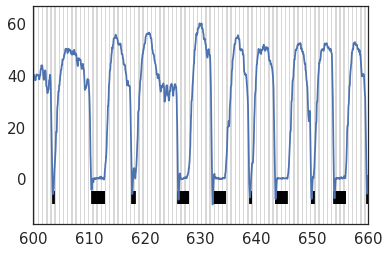

In [24]:
plt.plot(running_data['time'], running_data['running_speed'])
plt.vlines(dataset.licks['time'], -10, -5, label='licks')
for index in dataset.stimulus_table.index:
    row_data = dataset.stimulus_table.iloc[index]
    plt.axvspan(xmin=row_data.start_time,xmax=row_data.end_time,facecolor='gray',alpha=0.3)
plt.xlim(600,660)

In [161]:
one_session = dataset_pull(639253368)

In [164]:

dataset_pull()

In [205]:
def cell_survey(session, l0 = False, all_cells = False, xlim1 = 0, xlim2 = 200):
    #this function inputs a session_id and outputs graphs for the activity of cells in that session
    #optional arguments for l0 detection, survey of all cells, and variable xlims
    session = dataset_pull(session)
    cells = session.cell_specimen_ids
    time, dff_trace = one_session.get_dff_traces()
    if l0 == True:
        l0_events = l0_event_pull(session)
    idx = 0
    if all_cells == True:
        figsize = (plotx, 5)
        plot_x = len(cells)
        f, ax = plt.subplots(plot_x, 1, figsize=fig_size)
        ax = ax.ravel()
        print(ax)
        for n, cell in enumerate(cells):
            ax[idx].set_xlim(xlim1, xlim2)
            ax[idx].set_title('Cell ID '+str(cells[n]))
            ax[idx].plot(time, dff_trace[n])
            idx +=1
        return(ax)
    else:
        f, ax = plt.subplots()
        
        ax.set_xlim(xlim1, xlim2)
        ax.set_title('Cell ID '+str(cells[0]))
        ax.plot(time, dff_trace[0])
        return(figure)

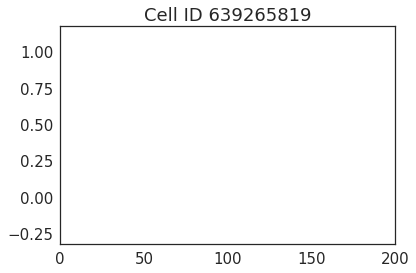

In [204]:
cell_survey(639253368)

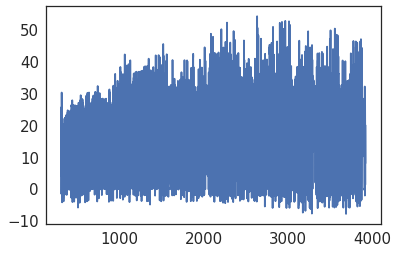

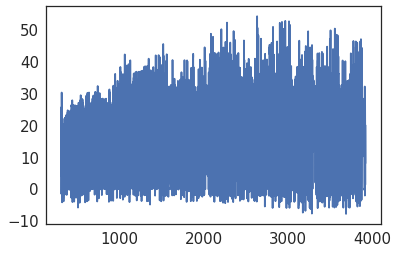

In [68]:
run1 = one_session.running_speed
run2 = one_session.get_running_speed()
plt.plot( run1['time'],run1['running_speed'])
plt.show()
plt.plot( run2['time'],run2['running_speed'])
plt.show()

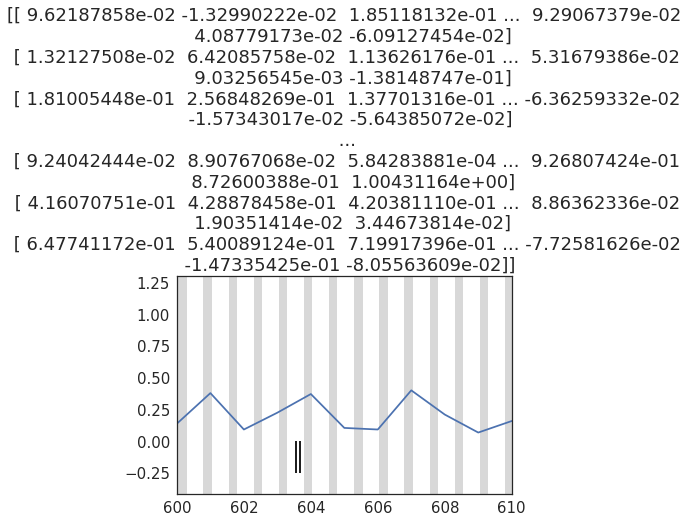

KeyboardInterrupt: 

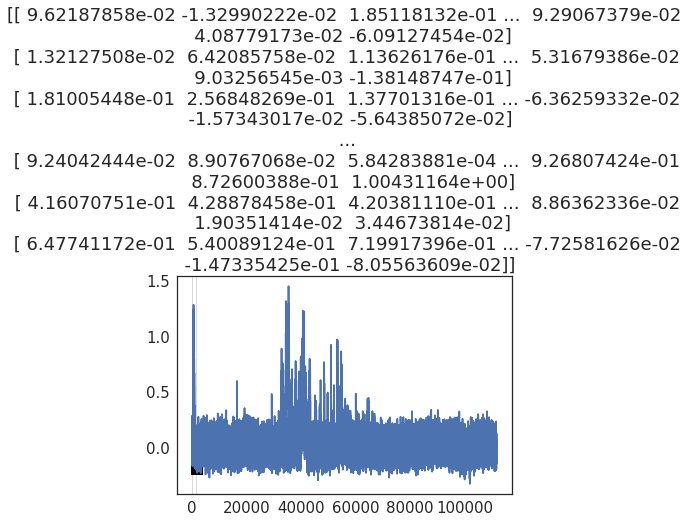

In [19]:
for i, row in enumerate(manifest):
    session = manifest.loc['experiment_id']
    analysis = ResponseAnalysis(session)
    manifest.experiment_id
    manifest.
    plt.plot(dff_t[i])
    plt.title(str(dff_trace))
    plt.vlines(dataset.licks['time'], 0, -0.25, label='licks')
    for index in dataset.stimulus_table.index:
        row_data = dataset.stimulus_table.iloc[index]
        plt.axvspan(xmin=row_data.start_time,xmax=row_data.end_time,facecolor='gray',alpha=0.3)
    plt.xlim(600,610)
    plt.show()

In [69]:
ls /data/dynamic-brain-worshop/visual_behavior_events

ls: cannot access /data/dynamic-brain-worshop/visual_behavior_events: No such file or directory


In [32]:
manifest.experiment_id

0     644942849
1     645035903
2     645086795
3     645362806
4     646922970
5     647108734
6     647551128
7     647887770
8     648647430
9     649118720
10    649318212
11    652844352
12    653053906
13    653123781
14    639253368
15    639438856
16    639769395
17    639932228
18    661423848
19    663771245
20    663773621
21    665286182
22    670396087
23    671152642
24    672185644
25    672584839
26    685744008
27    686726085
28    695471168
29    696136550
30    698244621
31    698724265
32    700914412
33    701325132
34    702134928
35    702723649
36    692342909
37    692841424
38    693272975
39    693862238
40    712178916
41    712860764
42    713525580
43    714126693
44    715161256
45    715887497
46    716327871
47    716600289
48    715228642
49    715887471
50    716337289
51    716602547
52    720001924
53    720793118
54    723064523
55    723750115
56    719321260
57    719996589
58    723748162
59    723037901
Name: experiment_id, dtype: int64

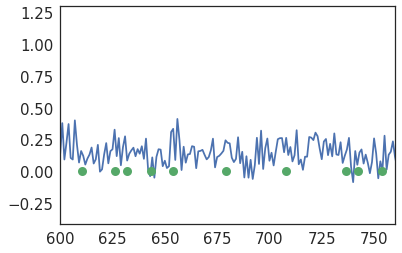

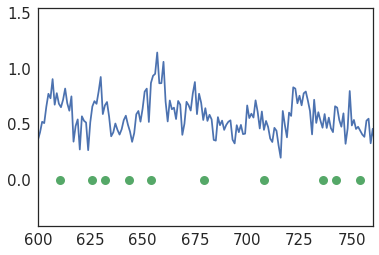

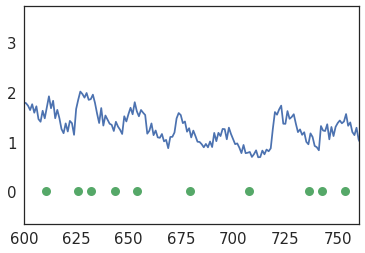

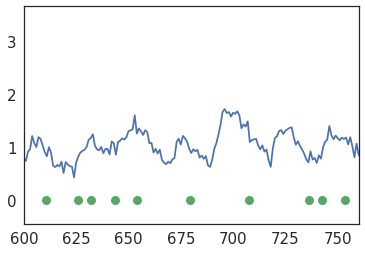

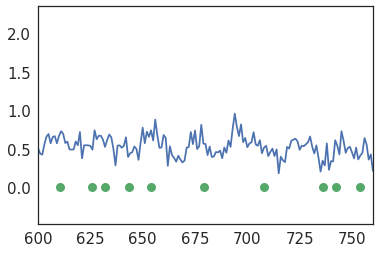

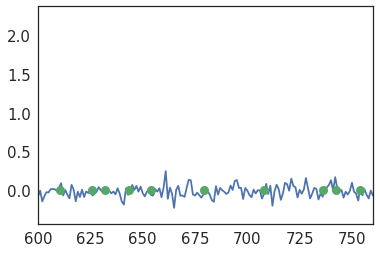

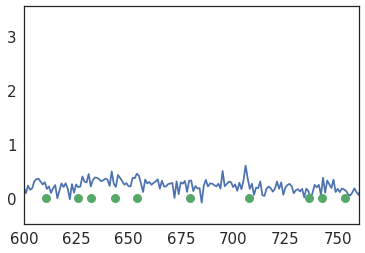

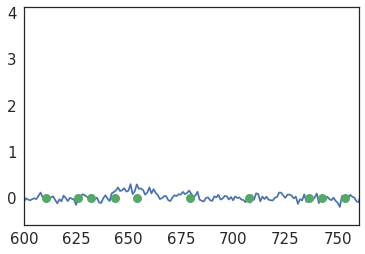

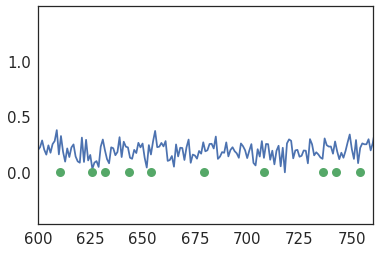

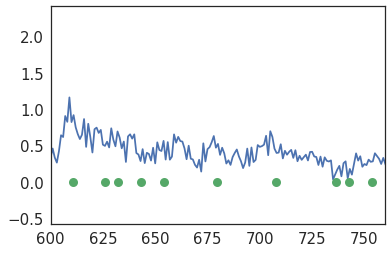

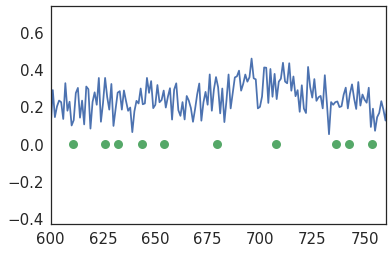

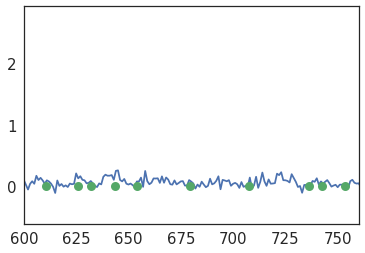

In [64]:
for i in range(len(dff_trace)):
    plt.plot(dff_trace[i])
    reward_y_vals = np.repeat(-0,repeats=len(dataset.rewards.time.values))
    plt.plot(dataset.rewards.time.values,reward_y_vals,marker='o',linestyle='None',label='rewards',)
    plt.xlim(600,760)
    plt.show()



In [33]:
analysis = ResponseAnalysis(dataset)
type(analysis)


OSError: unable to locate analysis folder for experiment [644942849, 645035903, 645086795, 645362806, 646922970, 647108734, 647551128, 647887770, 648647430, 649118720, 649318212, 652844352, 653053906, 653123781, 639253368, 639438856, 639769395, 639932228, 661423848, 663771245, 663773621, 665286182, 670396087, 671152642, 672185644, 672584839, 685744008, 686726085, 695471168, 696136550, 698244621, 698724265, 700914412, 701325132, 702134928, 702723649, 692342909, 692841424, 693272975, 693862238, 712178916, 712860764, 713525580, 714126693, 715161256, 715887497, 716327871, 716600289, 715228642, 715887471, 716337289, 716602547, 720001924, 720793118, 723064523, 723750115, 719321260, 719996589, 723748162, 723037901] in /data/dynamic-brain-workshop/visual_behavior

In [32]:
stims = dataset.get_stimulus_table()
images = stims['image_name'].unique()
for png in images:
    print(png)
    pic = dataset.stimulus_template(str(png))
    plt.imshow(pic, cmap='gray')

im062


TypeError: 'numpy.ndarray' object is not callable

In [102]:
a_file = dataset.get_analysis_dir()
print(os.listdir(a_file))
#analysis_file = pd.read_csv(os.path.normpath(a_file))
dataset.

['644919226_329071_20171024103315_stim.pkl', '644919226_329071_20171024103315_sync.h5', 'dff_traces.h5', 'flash_response_df.h5', 'image_responses', 'licks.h5', 'max_intensity_projection.png', 'max_projection.h5', 'metadata.h5', 'motion_correction.h5', 'rewards.h5', 'roi_masks.h5', 'roi_metrics.h5', 'running_speed.h5', 'stimulus_metadata.h5', 'stimulus_table.h5', 'stimulus_template.h5', 'task_parameters.h5', 'timestamps.h5', 'trial_response_df.h5', 'trials.h5']


{'estimated_calcium': None, 'spikes': array([35415, 35420, 35425, 83453, 83579, 83585], dtype=int32), 'spike_mag': None, 'EPS': 1e-10, 'dat': array([ 0.09621879, -0.01329902,  0.18511813, ...,  0.09290674,
        0.04087792, -0.06091275]), 'gam': 0.315, 'end_vec': array([83584, 83584, 83584, ...,     0,     0,     0], dtype=int32), 'change_pts': array([    0, 35414, 35419, 35424, 83452, 83578, 83584], dtype=int32), 'pos_spike_mag': None}


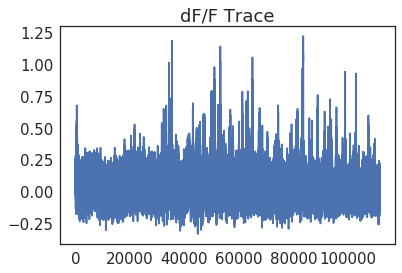

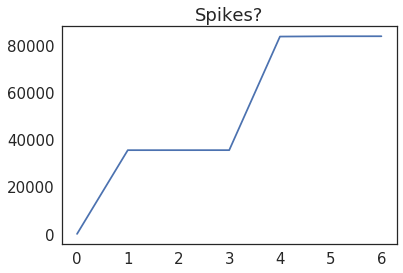

In [14]:
l0_trace = estimate_spikes(dff_trace[0], 0.315, 1)
print(l0_trace)
#for key in l0_trace.keys():
    #print(len(l0_trace[key]))
plt.plot(l0_trace['dat'])
plt.title('dF/F Trace')
plt.show()
plt.plot(l0_trace['change_pts'])
plt.title('Spikes?')
plt.show()
#c = np.corrcoef(l0_trace['dat'], l0_trace['end_vec'])
#print(c)
#plt.imshow(c, interpolation='none')

37


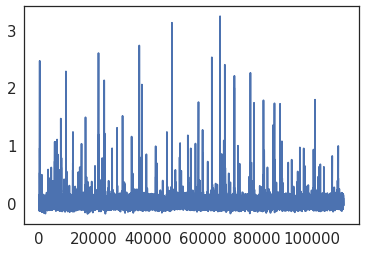

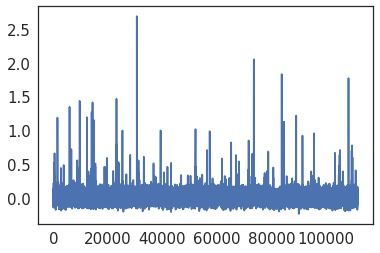

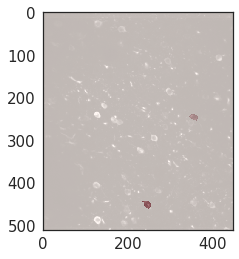

In [180]:
sc = np.corrcoef(dff_trace)
#plt.imshow(sc, interpolation='none')
#plt.colorbar()

df_sc = pd.DataFrame(sc)
print((df_sc[0][1:].idxmax()))
#plt.plot(df_sc[0][1:])
plt.plot(dff_trace[37])
plt.show()
plt.plot(dff_trace[0])
plt.show()
mp = dataset.get_max_projection()
plt.imshow(mp, cmap='gray')
rois = dataset.get_roi_mask_array()
plt.imshow(rois[0,:,:], cmap='Reds', alpha=0.5)
plt.imshow(rois[37,:,:], cmap='Reds', alpha=0.5)

In [ ]:
dataset_dic = {}
for i, experiment in enumerate(experiment_list):
    dataset_dic['%s' % experiment] = VisualBehaviorOphysDataset(experiment_list[i], cache_dir=drive_path)
dataset_dic  

In [137]:
dataset_dic['639932228'].get_dff_traces()

(array([  175.06314,   175.09542,   175.12771, ...,  3780.45561,
         3780.48791,  3780.52021]),
 array([[-0.11828023, -0.08908008, -0.0587226 , ..., -0.09490582,
         -0.16798646, -0.18912138],
        [ 0.1236022 ,  0.01501087,  0.11876162, ..., -0.13592385,
         -0.14967096, -0.24869881],
        [ 0.0585711 ,  0.0609616 , -0.0759083 , ..., -0.15004444,
         -0.2271982 , -0.10661019],
        ..., 
        [-0.01174926, -0.11135835, -0.0185124 , ..., -0.11000928,
         -0.21413133, -0.10590366],
        [ 0.0079844 , -0.1352217 , -0.0453183 , ...,  0.09212427,
         -0.08097138, -0.16338535],
        [-0.00826806,  0.01847261,  0.07265201, ...,  0.0527428 ,
         -0.18848167, -0.09649406]]))

In [138]:
dataset_dic['644942849'].get_dff_traces()

(array([   71.76094,    71.79323,    71.82551, ...,  3678.40198,
         3678.43428,  3678.46658]),
 array([[  9.62187858e-02,  -1.32990222e-02,   1.85118132e-01, ...,
           9.29067379e-02,   4.08779173e-02,  -6.09127454e-02],
        [  1.32127508e-02,   6.42085758e-02,   1.13626176e-01, ...,
           5.31679386e-02,   9.03256545e-03,  -1.38148747e-01],
        [  1.81005448e-01,   2.56848269e-01,   1.37701316e-01, ...,
          -6.36259332e-02,  -1.57343017e-02,  -5.64385072e-02],
        ..., 
        [  9.24042444e-02,   8.90767068e-02,   5.84283881e-04, ...,
           9.26807424e-01,   8.72600388e-01,   1.00431164e+00],
        [  4.16070751e-01,   4.28878458e-01,   4.20381110e-01, ...,
           8.86362336e-02,   1.90351414e-02,   3.44673814e-02],
        [  6.47741172e-01,   5.40089124e-01,   7.19917396e-01, ...,
          -7.72581626e-02,  -1.47335425e-01,  -8.05563609e-02]]))

In [139]:
dff_trace_dic={}
for experiment in experiment_list:
    print(experiment)
    dataset = dataset_dic[str(experiment)]
    print(dataset)
    trash, dff_trace_dic['%s' %experiment] = dataset.get_dff_traces()
    #print(dff_trace_dic)
dff_trace_dic

644942849
645035903
645086795
645362806
646922970
647108734
647551128
647887770
648647430
649118720
649318212
652844352
653053906
653123781
639253368
639438856
639769395
639932228
661423848
663771245
663773621
665286182
670396087
671152642
672185644
672584839
685744008
686726085
695471168
696136550
698244621
698724265
700914412
701325132
702134928
702723649
692342909
692841424
693272975
693862238
712178916
712860764
713525580
714126693
715161256
715887497
716327871
716600289
715228642
715887471
716337289
716602547
720001924
720793118
723064523
723750115
719321260
719996589
723748162
723037901


{'639253368': array([[ 0.08961204,  0.03972647, -0.07046237, ..., -0.03976627,
         -0.00295955, -0.0317463 ],
        [ 0.02472758, -0.03159859, -0.06160281, ...,  0.14874703,
          0.04210731, -0.11267985],
        [-0.03567422,  0.07143925,  0.00335884, ...,  0.0537289 ,
         -0.12069288, -0.117939  ],
        ..., 
        [-0.08235584, -0.05687811, -0.12262307, ..., -0.05459438,
         -0.13602593, -0.16684157],
        [ 0.09086994,  0.02343508,  0.08449386, ..., -0.05257615,
         -0.06339255, -0.06758662],
        [ 0.06775124, -0.07994324, -0.02172137, ...,  0.08436095,
          0.001634  , -0.11564899]]),
 '639438856': array([[-0.08877653,  0.04554007, -0.04015399, ...,  0.04938318,
         -0.23278375, -0.2205185 ],
        [ 0.02188279, -0.08382686, -0.14709918, ..., -0.06983097,
         -0.23818514, -0.36809347],
        [-0.10971203, -0.05654456,  0.07868886, ..., -0.12907549,
         -0.02000462, -0.05890092],
        ..., 
        [-0.03943937, -0.1

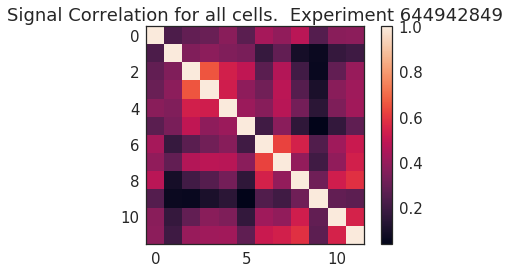

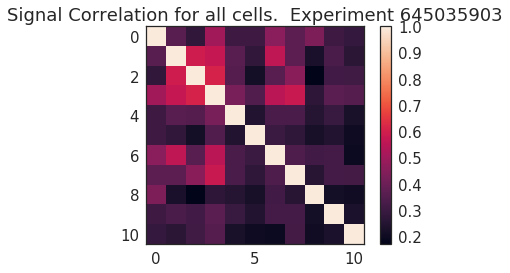

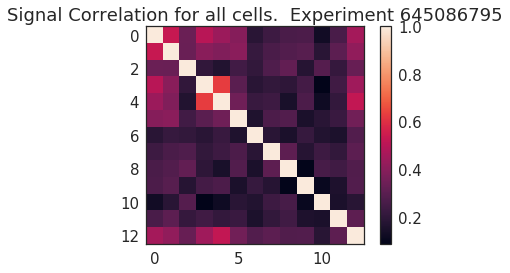

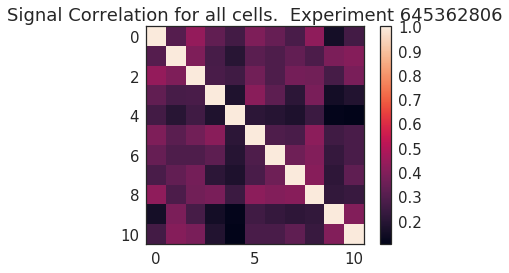

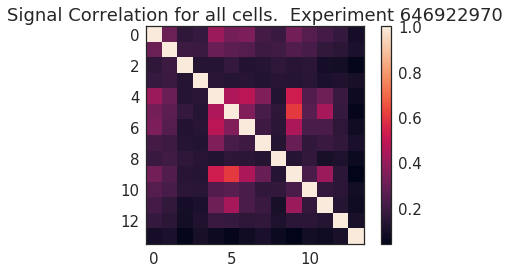

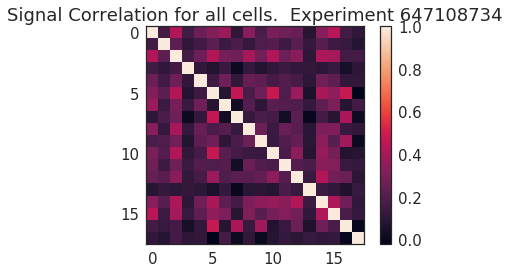

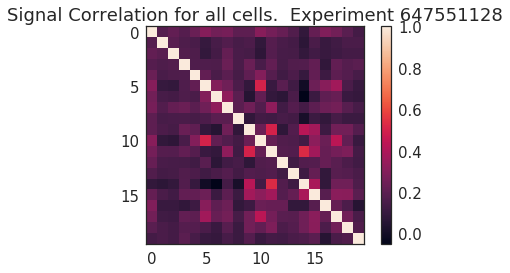

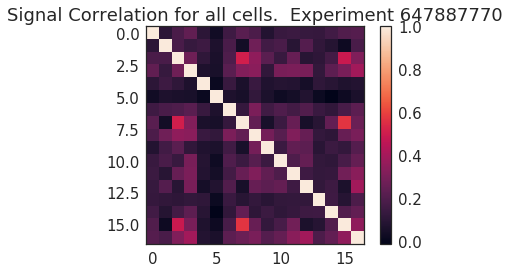

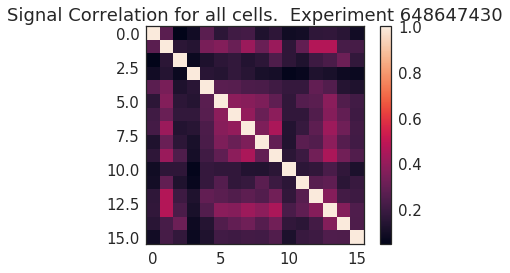

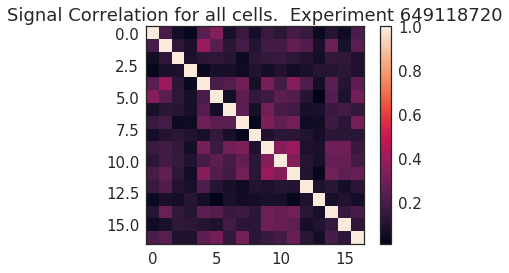

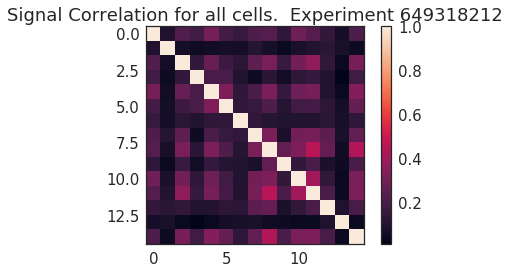

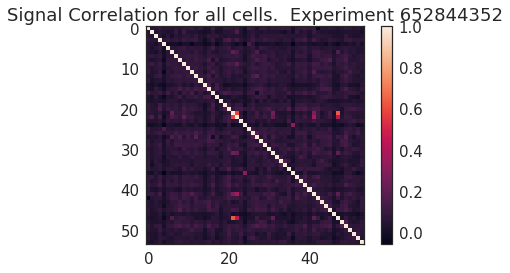

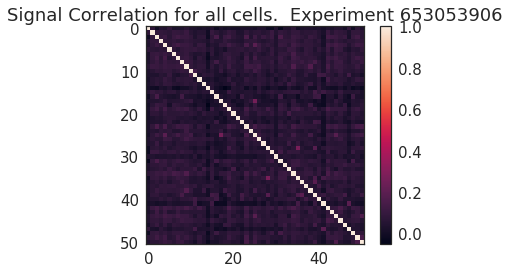

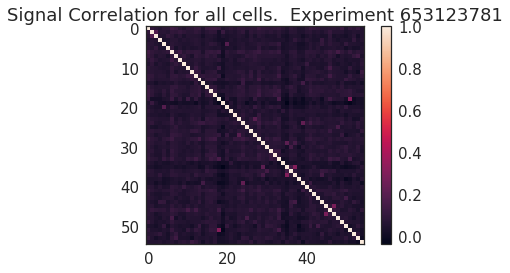

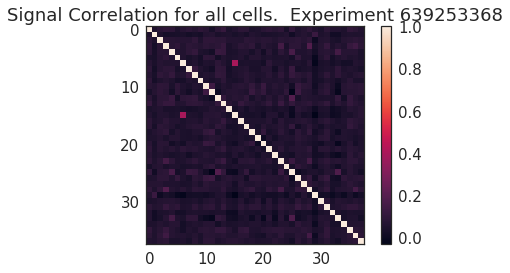

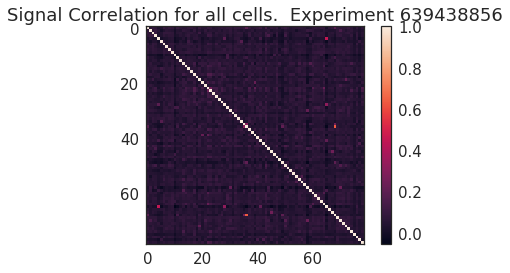

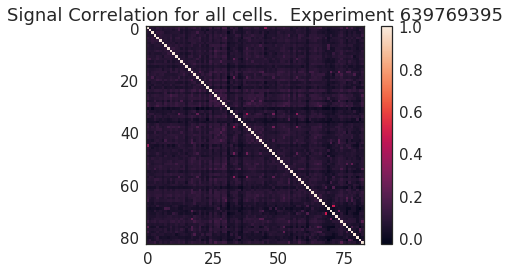

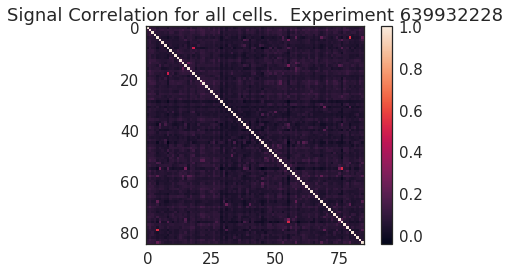

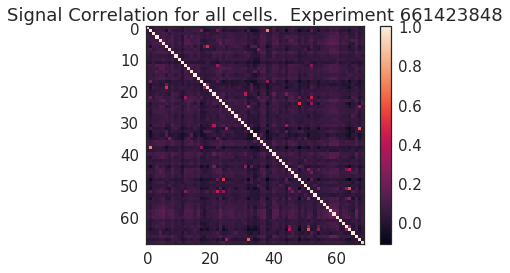

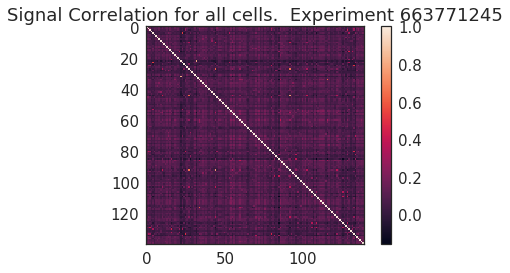

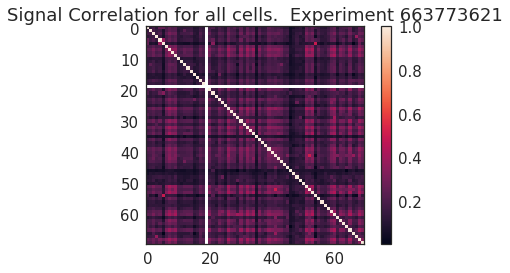

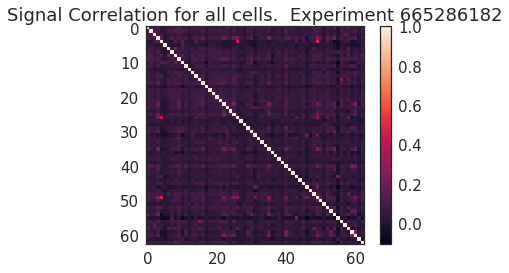

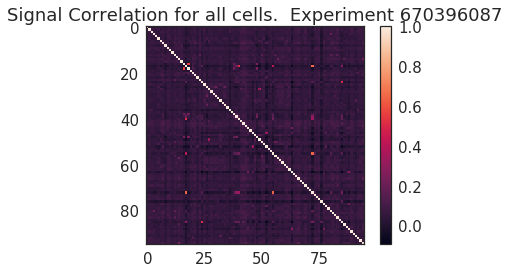

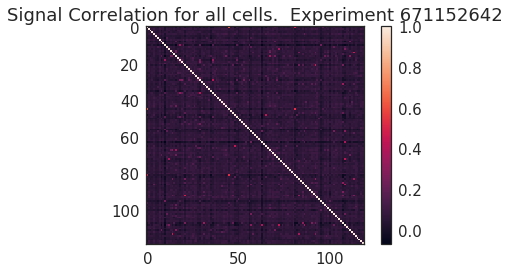

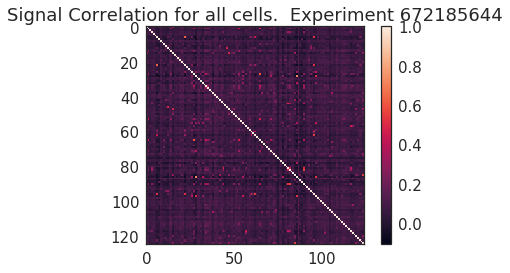

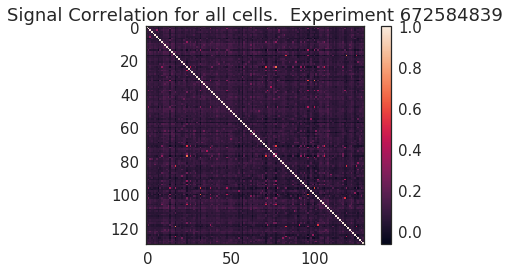

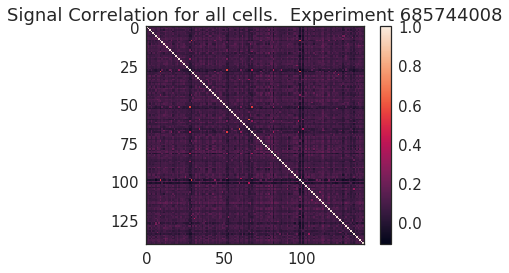

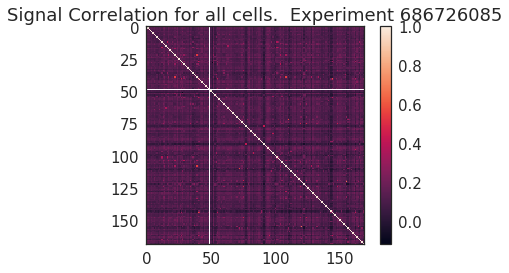

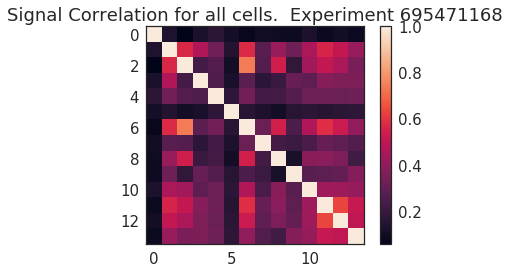

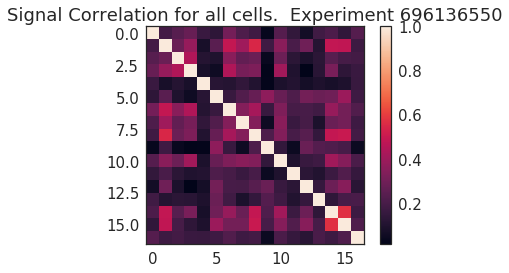

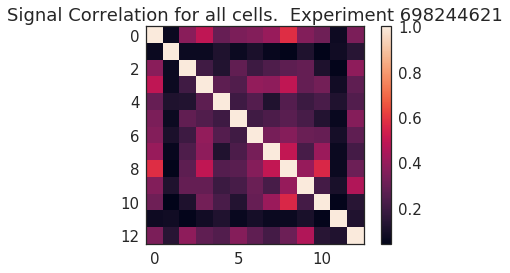

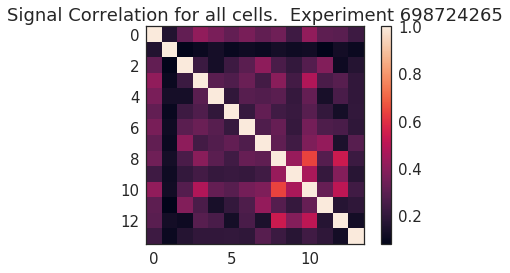

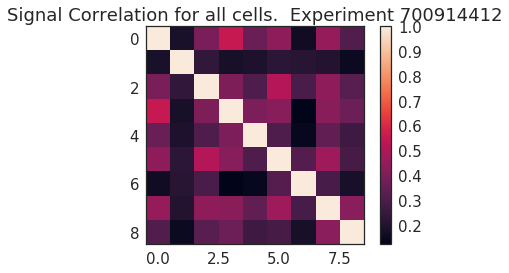

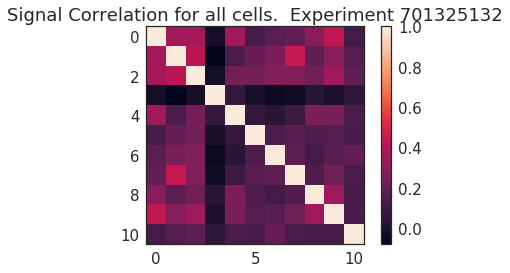

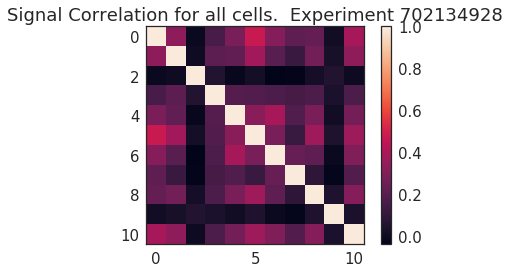

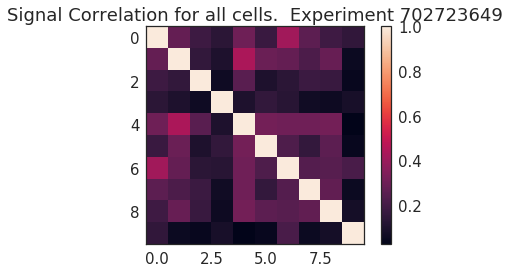

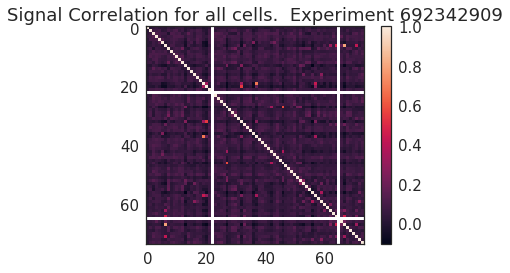

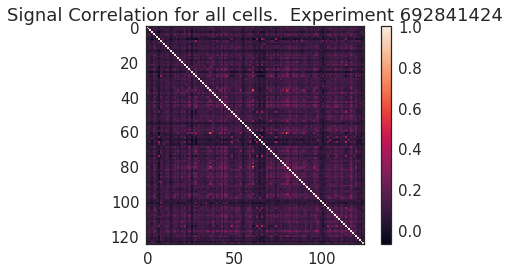

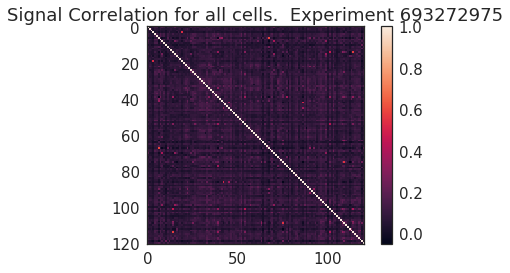

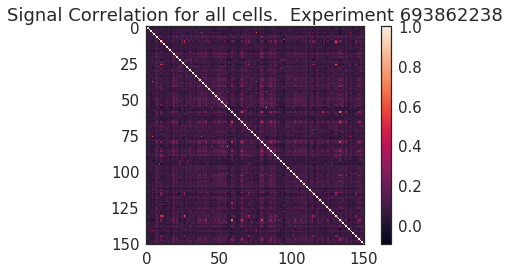

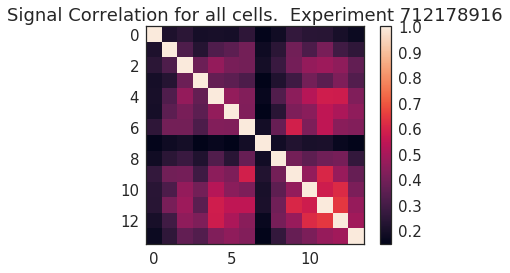

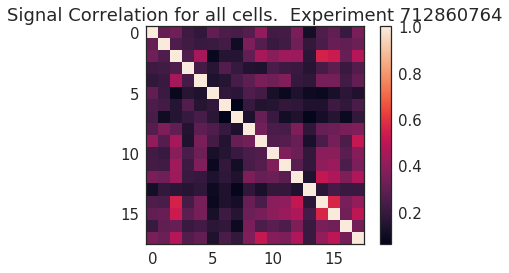

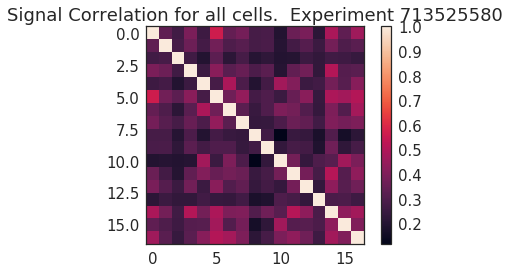

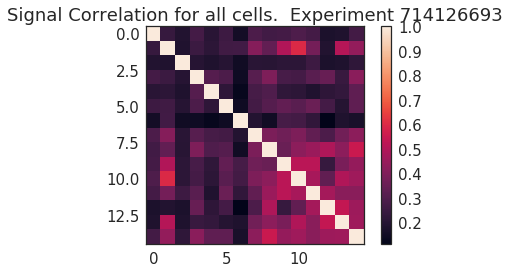

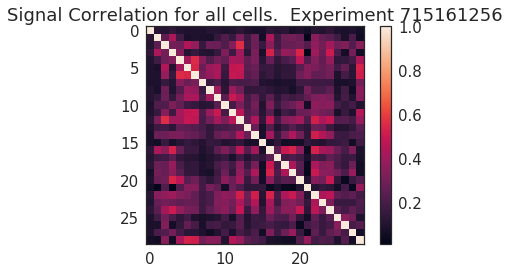

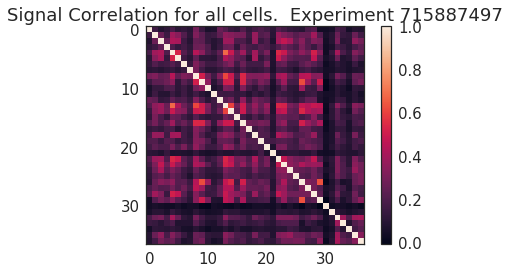

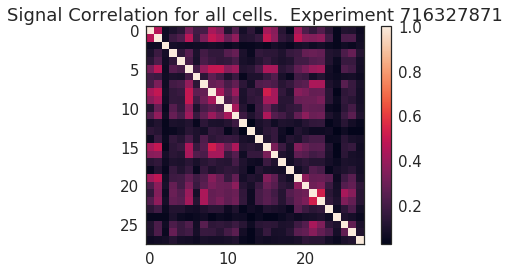

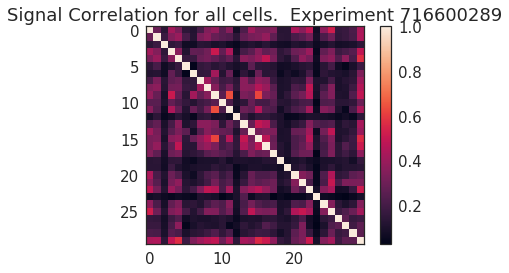

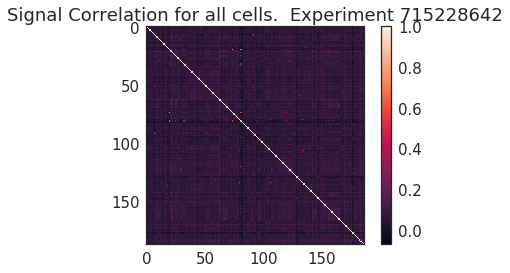

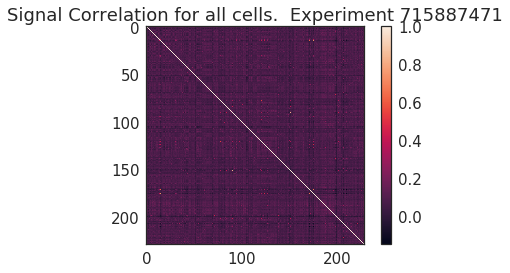

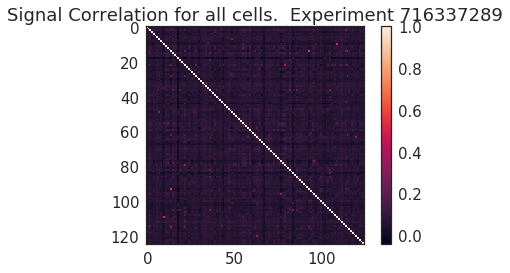

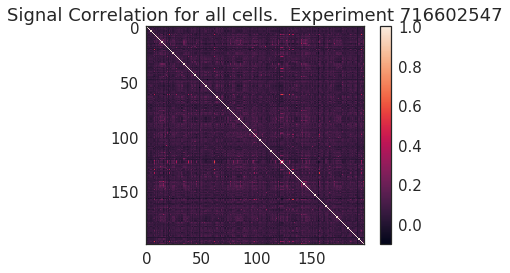

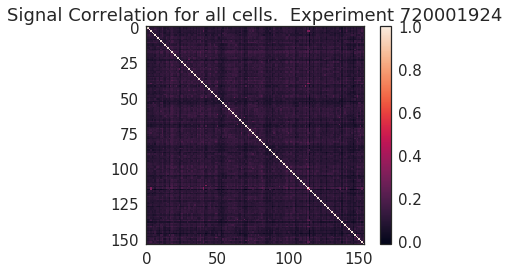

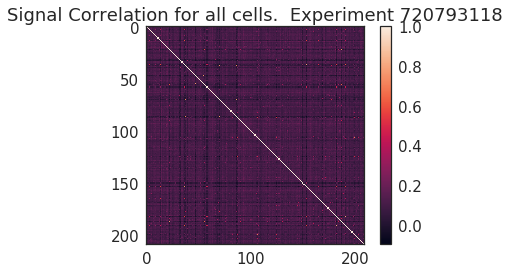

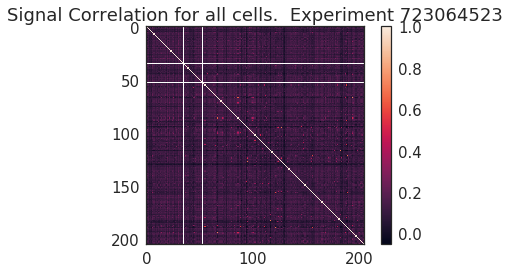

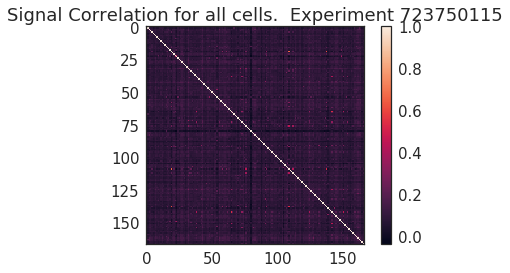

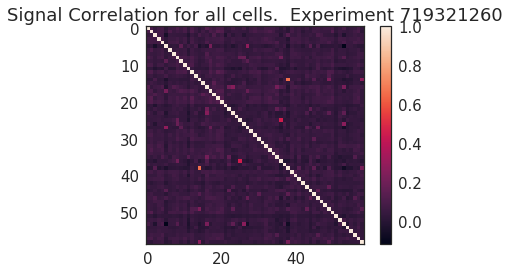

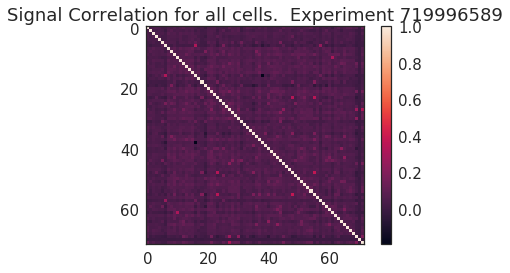

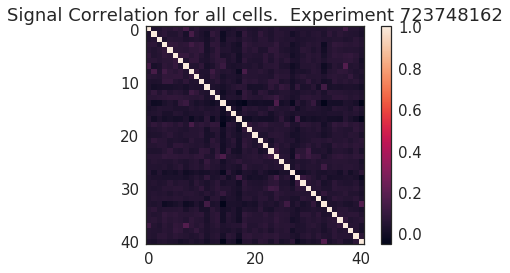

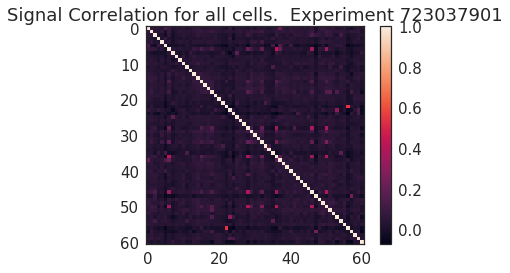

In [140]:
for experiment in experiment_list:
    dff_trace = dff_trace_dic[str(experiment)]
    sc = np.corrcoef(dff_trace)
    plt.imshow(sc, interpolation='none')
    plt.colorbar()
    plt.title('Signal Correlation for all cells.  Experiment '+str(experiment))
    plt.show()